In [1]:
!pip3 install catboost
!pip install xgboost

     |████████████████████████████████| 76.6 MB 1.4 MB/s 


**Прогнозирование стоимости автомобиля по характеристикам**

In [115]:
# подключение пакетов
# общие пакеты
from itertools import combinations
from scipy.stats import ttest_ind
import re
import sys
import itertools
import datetime
from datetime import datetime
from tqdm.notebook import tqdm

# математические пакеты
import pandas as pd
import numpy as np
import pandas_profiling

# пакеты визуализации
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# ML пакеты
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
from catboost import CatBoostRegressor
import xgboost as xgb

from hyperopt import tpe, hp, fmin, STATUS_OK, Trials
from hyperopt.pyll.base import scope
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок


# Загрузка и первичный анализ данных

In [116]:
RANDOM_SEED = 42  # фиксируем RANDOM_SEED для воспроизводимости результатов
VAL_SIZE= 0.20

In [117]:
train = pd.read_csv('Parsed_avto.csv') # спарсенный датасет на середину ноября 2021 года
test = pd.read_csv('test.csv')        # тестовый датасет
sample_submission = pd.read_csv('sample_submission.csv')

Просмотрим информацию по загруженным данным

In [118]:
train.head(2)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владение,Владельцы,ПТС,Привод,Руль,Состояние,Таможня,price
0,лифтбек,VOLKSWAGEN,https://auto.ru/cars/used/sale/volkswagen/polo...,синий,"{'id': '22153111', 'name': 'Status', 'availabl...",Автомобиль продается дилерским центром «РРТ-Ав...,1.4 LTR,125 N12,"{'cruise-control': True, 'asr': True, 'esp': T...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,1000.0,2020.0,"{'code': 'POLO', 'name': 'Polo', 'ru_name': 'П...",Polo,1.4 AMT (125 л.с.),5.0,1636557439,RUB,2021.0,1.105535e+09,"{'id': '21802423', 'name': '', 'nameplate': ''...",LIFTBACK ROBOT 1.4,роботизированная,EUROPEAN,NaN,1 владелец,Оригинал,передний,Левый,Не требует ремонта,Растаможен,1300000.0
1,внедорожник 5 дв.,VOLKSWAGEN,https://auto.ru/cars/used/sale/volkswagen/tigu...,белый,"{'id': '22688476', 'name': 'Respect', 'availab...",Автомобиль продается дилерским центром «РРТ-Ав...,1.4 LTR,150 N12,"{'cruise-control': True, 'asr': True, 'esp': T...",бензин,https://autoru.naydex.net/8Sxn7GU56/250ef8kLXY...,1000.0,2020.0,"{'code': 'TIGUAN', 'name': 'Tiguan', 'ru_name'...",Tiguan,1.4 AMT (150 л.с.),5.0,1636557441,RUB,2021.0,1.105535e+09,"{'id': '22680193', 'name': '', 'nameplate': ''...",ALLROAD_5_DOORS ROBOT 1.4,роботизированная,EUROPEAN,NaN,1 владелец,Оригинал,передний,Левый,Не требует ремонта,Растаможен,2200000.0


In [119]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86713 entries, 0 to 86712
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              86563 non-null  object 
 1   brand                 86563 non-null  object 
 2   car_url               86713 non-null  object 
 3   color                 86563 non-null  object 
 4   complectation_dict    84999 non-null  object 
 5   description           86563 non-null  object 
 6   engineDisplacement    86563 non-null  object 
 7   enginePower           86563 non-null  object 
 8   equipment_dict        86562 non-null  object 
 9   fuelType              86563 non-null  object 
 10  image                 86638 non-null  object 
 11  mileage               86562 non-null  float64
 12  modelDate             86563 non-null  float64
 13  model_info            86562 non-null  object 
 14  model_name            86562 non-null  object 
 15  name               

In [120]:
test.head(2)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,74000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.2 AMT (105 л.с.),5,1603226273,RUB,2014,1100575026,"{""id"":""10373605"",""displacement"":1197,""engine_t...",LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,60563,2017,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 MT (110 л.с.),5,1603226277,RUB,2017,1100549428,"{""id"":""20913311"",""displacement"":1598,""engine_t...",LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [121]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

На первый взгляд структура обучающей и тестовой выборок одинаковы, проверим различаются ли по количеству и наименованию колонок датасеты

In [122]:
set(test.columns).difference(train.columns)

set()

различий нет, по набору колонок датасеты идентичны, объёдиним датасеты и проведём анализ данных

In [123]:
# объединяем трейн и тест в один датасет
train['sample'] = 1  # помечаем трейн
test['sample'] = 0  # помечаем тест
test['price'] = 0  # целевая переменная в тесте отсутствует, добавим и заполним нулями
df = test.append(train, sort=False).reset_index(drop=True)  # объединяем

переименуем столбцы, названные порусски поанглийски

In [124]:
df = df.rename(columns={'Владение': 'ownership', 'Владельцы': 'owner', 
                        'ПТС': 'PTS','Привод': 'gear', 'Руль': 'helm', 
                        'Состояние': 'condition', 'Таможня': 'customs'})

Проверим сколько пустых записей в объединенном датасете

In [125]:
df.isnull().sum()

bodyType                  150
brand                     150
car_url                     0
color                     150
complectation_dict      29982
description               150
engineDisplacement        150
enginePower               150
equipment_dict          10147
fuelType                  150
image                      75
mileage                   151
modelDate                 150
model_info                151
model_name                151
name                      151
numberOfDoors             150
parsing_unixtime            0
priceCurrency              29
productionDate            150
sell_id                   151
super_gen                 151
vehicleConfiguration      150
vehicleTransmission       150
vendor                   2330
owner                     156
ownership               84726
PTS                       154
gear                      151
helm                      151
condition                 151
customs                   368
sample                      0
price     

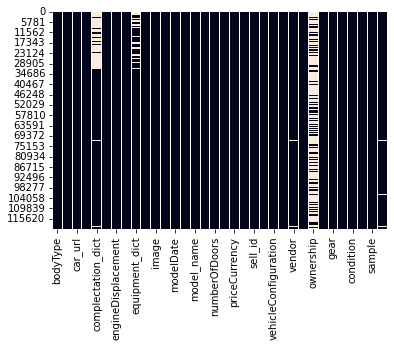

In [126]:
sns.heatmap(df.isna(), cbar=False)

Присутствует 151 строка, с практически отсутствующими данными - удалим их,
так же обращает на себя внимание большое количество пустых данных в колонках ownership, complectation_dict, equipment_dict и prise рассмотрим их более внимательно ниже.

In [127]:
# удаляем пустые строки
df = df.dropna(subset=['name'])

In [128]:
df.isnull().sum()

bodyType                    0
brand                       0
car_url                     0
color                       0
complectation_dict      29831
description                 0
engineDisplacement          0
enginePower                 0
equipment_dict           9996
fuelType                    0
image                      46
mileage                     0
modelDate                   0
model_info                  0
model_name                  0
name                        0
numberOfDoors               0
parsing_unixtime            0
priceCurrency               0
productionDate              0
sell_id                     0
super_gen                   0
vehicleConfiguration        0
vehicleTransmission         0
vendor                   2179
owner                       5
ownership               84575
PTS                         3
gear                        0
helm                        0
condition                   0
customs                   217
sample                      0
price     

осталось не большое количество пропусков, посмотрим на каждый столбец прицельно и оценим структуру данных в них.

In [129]:
df['bodyType'].value_counts() 

седан                      42239
внедорожник 5 дв.          40665
хэтчбек 5 дв.              10605
лифтбек                     6034
универсал 5 дв.             5752
минивэн                     4116
компактвэн                  3134
купе                        2594
хэтчбек 3 дв.               2256
пикап двойная кабина        1080
фургон                       591
внедорожник 3 дв.            571
купе-хардтоп                 451
родстер                      373
кабриолет                    368
микровэн                     188
седан-хардтоп                146
пикап одинарная кабина        27
пикап полуторная кабина       16
лимузин                       13
внедорожник открытый          12
седан 2 дв.                    7
тарга                          6
фастбек                        2
спидстер                       2
Name: bodyType, dtype: int64

In [130]:
df['brand'].unique()

array(['SKODA', 'AUDI', 'HONDA', 'VOLVO', 'BMW', 'NISSAN', 'INFINITI',
       'MERCEDES', 'TOYOTA', 'LEXUS', 'VOLKSWAGEN', 'MITSUBISHI',
       'RENAULT', 'PORSCHE', 'MAZDA', 'ROLLS_ROYCE', 'OPEL', 'LAND_ROVER',
       'LAMBORGHINI', 'SUZUKI', 'CITROEN', 'PEUGEOT', 'SUBARU', 'MINI',
       'JAGUAR', 'FIAT', 'FERRARI', 'BENTLEY', 'SEAT', 'SMART', 'DATSUN',
       'SAAB', 'DAIHATSU', 'ALFA_ROMEO', 'ACURA', 'MASERATI', 'MAYBACH',
       'DACIA', 'LANCIA', 'WARTBURG', 'TATRA', 'ARO', 'ISUZU', 'ROVER',
       'HYUNDAI', 'ASTON_MARTIN', 'METROCAB', 'PUCH', 'MITSUOKA', 'MG',
       'LOTUS', 'DAIMLER', 'ALPINA', 'BRABUS', 'ARIEL', 'LIGIER',
       'BUGATTI', 'AC', 'MCLAREN', 'DS', 'MATRA', 'TRIUMPH'], dtype=object)

In [131]:
df['color'].value_counts()

чёрный         32772
белый          23804
серый          16165
серебристый    14541
синий          11566
красный         6205
коричневый      4526
зелёный         4181
бежевый         2060
голубой         1613
золотистый       924
пурпурный        892
фиолетовый       783
жёлтый           627
оранжевый        533
розовый           56
Name: color, dtype: int64

In [132]:
df['owner'].value_counts() 

3 или более    59492
1 владелец     25307
2 владельца    17715
1 владелец      9459
2 владельца     9270
Name: owner, dtype: int64

In [133]:
df.loc[(df['owner'].isna()) & (df['mileage'] == 0.0), 'owner'] = 0

In [134]:
df[df['owner'].isna()].productionDate.unique()

array([1990., 1995., 1999., 2001., 2006.])

In [135]:
df['PTS'].value_counts() 

Оригинал    101824
Дубликат     19421
Name: PTS, dtype: int64

In [136]:
df['customs'].value_counts() 

Растаможен       120957
Не растаможен        74
Name: customs, dtype: int64

In [137]:
df['numberOfDoors'].value_counts()

5.0    68233
4.0    46074
2.0     3870
3.0     3068
0.0        3
Name: numberOfDoors, dtype: int64

In [138]:
# посмотрим что за автомобили без дверей
df[df['numberOfDoors'] == 0]

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,owner,ownership,PTS,gear,helm,condition,customs,sample,price
16944,кабриолет,MERCEDES,https://auto.ru/cars/used/sale/mercedes/simple...,белый,NaN,"на ходу. 1904 год. стоит в гараже, пылится.Кат...",5.3 LTR,32 N12,NaN,бензин,https://autoru.naydex.net/ESooa9149/468b9eoMem...,48000.0,1904.0,"{""code"":""SIMPLEX"",""name"":""Simplex"",""ru_name"":""...",SIMPLEX,5.3 MT (32 л.с.),0.0,1603245843,RUB,1904.0,1.093802e+09,"{""id"":""21743990"",""displacement"":5322,""engine_t...",CABRIO MECHANICAL 5.3,механическая,EUROPEAN,1 владелец,6 лет и 8 месяцев,Оригинал,задний,Правый,Не требует ремонта,Растаможен,0,0.0
77079,родстер,ARIEL,https://auto.ru/cars/used/sale/ariel/atom/1100...,красный,"{'id': '0', 'name': ''}","Ariel Atom 3 ( 300 сил), вес 550кг, 2009 год ...",2.0 LTR,300 N12,{},бензин,https://autoru.naydex.net/9KMlCK149/4909feykk_...,18000.0,1996.0,"{'code': 'ATOM', 'name': 'Atom', 'ru_name': 'А...",Atom,2.0 MT (300 л.с.),0.0,1636833333,RUB,2009.0,1.100324e+09,"{'id': '20465510', 'name': '', 'nameplate': ''...",ROADSTER MECHANICAL 2.0,механическая,EUROPEAN,1 владелец,NaN,Оригинал,задний,Левый,Не требует ремонта,Растаможен,1,4590000.0
77586,родстер,LIGIER,https://auto.ru/cars/used/sale/ligier/js_51/11...,чёрный,"{'id': '0', 'name': ''}",Ligier JS51 год выпуска 2010\nШасси из алюмини...,2.0 LTR,250 N12,"{'13-inch-wheels': True, 'steering-wheel-gear-...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,4000.0,2009.0,"{'code': 'JS_51', 'name': 'JS 51', 'ru_name': ...",JS 51,2.0 AMT (250 л.с.),0.0,1636836242,RUB,2010.0,1.102578e+09,"{'id': '21295872', 'name': '', 'nameplate': ''...",ROADSTER ROBOT 2.0,роботизированная,EUROPEAN,2 владельца,4 года и 8 месяцев,Оригинал,задний,Левый,Не требует ремонта,Растаможен,1,5310000.0


Это родстеры и старый кабриолет - они вполне могут быть без дверей - оставим

In [139]:
df['ownership'].value_counts()

1 месяц                 989
2 месяца                904
3 месяца                844
10 месяцев              763
1 год и 1 месяц         724
                       ... 
28 лет и 3 месяца         1
27 лет и 11 месяцев       1
28 лет                    1
28 лет и 10 месяцев       1
34 года и 11 месяцев      1
Name: ownership, Length: 323, dtype: int64

In [140]:
df[df['ownership'].isna()].productionDate.unique()

array([2014., 2017., 2012., 2011., 2019., 2018., 2010., 2020., 2016.,
       2013., 2006., 2007., 2015., 2005., 2008., 2009., 1997., 2002.,
       2004., 2003., 2001., 2000., 1995., 1998., 1993., 1939., 1996.,
       1999., 1991., 1992., 1989., 1987., 1985., 1994., 1990., 1984.,
       1988., 1983., 1981., 1986., 1977., 1982., 1950., 1953., 1949.,
       1937., 1980., 1969., 1968., 1936., 1974., 1967., 1960., 1959.,
       1963., 1957., 1979., 1972., 1978., 2021., 1970., 1976., 1973.,
       1975.])

In [141]:
df['engineDisplacement'].unique()

array(['1.2 LTR', '1.6 LTR', '1.8 LTR', '2.0 LTR', '1.4 LTR', '1.3 LTR',
       '1.0 LTR', '3.6 LTR', '1.5 LTR', '1.9 LTR', '2.8 LTR', '1.1 LTR',
       '2.5 LTR', '4.2 LTR', '3.0 LTR', '4.0 LTR', '5.9 LTR', '2.7 LTR',
       '3.1 LTR', '2.4 LTR', '5.2 LTR', '3.2 LTR', '4.1 LTR', '6.3 LTR',
       '2.3 LTR', '6.0 LTR', '2.2 LTR', '3.7 LTR', '2.9 LTR', '5.0 LTR',
       '3.3 LTR', '2.1 LTR', '2.6 LTR', ' LTR', '3.5 LTR', '1.7 LTR',
       '0.7 LTR', '4.4 LTR', '4.8 LTR', '5.4 LTR', '6.6 LTR', '4.9 LTR',
       '3.8 LTR', '3.4 LTR', '3.9 LTR', '4.6 LTR', '5.6 LTR', '4.5 LTR',
       '5.5 LTR', '6.2 LTR', '4.7 LTR', '4.3 LTR', '5.8 LTR', '5.3 LTR',
       '5.7 LTR', '6.8 LTR', '0.6 LTR', '0.8 LTR', '6.5 LTR', '8.0 LTR',
       '0.9 LTR'], dtype=object)

In [142]:
df[df['engineDisplacement']==' LTR'].fuelType.unique()

array(['электро'], dtype=object)

In [143]:
df['enginePower'].unique()

array(['105 N12', '110 N12', '152 N12', '200 N12', '102 N12', '150 N12',
       '90 N12', '180 N12', '220 N12', '122 N12', '70 N12', '140 N12',
       '125 N12', '54 N12', '86 N12', '75 N12', '64 N12', '95 N12',
       '260 N12', '170 N12', '80 N12', '68 N12', '160 N12', '115 N12',
       '280 N12', '53 N12', '60 N12', '143 N12', '42 N12', '101 N12',
       '58 N12', '193 N12', '79 N12', '30 N12', '100 N12', '50 N12',
       '163 N12', '225 N12', '420 N12', '211 N12', '245 N12', '560 N12',
       '500 N12', '249 N12', '450 N12', '605 N12', '250 N12', '354 N12',
       '120 N12', '290 N12', '230 N12', '350 N12', '204 N12', '255 N12',
       '340 N12', '177 N12', '272 N12', '372 N12', '210 N12', '130 N12',
       '300 N12', '190 N12', '239 N12', '435 N12', '333 N12', '271 N12',
       '326 N12', '238 N12', '310 N12', '233 N12', '252 N12', '133 N12',
       '460 N12', '520 N12', '400 N12', '525 N12', '367 N12', '265 N12',
       '550 N12', '580 N12', '88 N12', '165 N12', '430 N12', '335 N

In [144]:
df['fuelType'].unique()

array(['бензин', 'дизель', 'гибрид', 'электро', 'газ'], dtype=object)

In [145]:
df['vehicleConfiguration'].unique()

array(['LIFTBACK ROBOT 1.2', 'LIFTBACK MECHANICAL 1.6',
       'LIFTBACK ROBOT 1.8', ..., 'PICKUP_ONE MECHANICAL 2.1',
       'WAGON_5_DOORS AUTOMATIC 4.8', 'ALLROAD_OPEN MECHANICAL 2.3'],
      dtype=object)

In [146]:
df['model_name'].unique()

array(['OCTAVIA', 'SUPERB', 'OCTAVIA_RS', ..., 'Rekord', '505',
       'G-modell'], dtype=object)

In [147]:
df['name'].value_counts()

1.6 AT (110 л.с.)        1177
1.6 MT (110 л.с.)         966
1.6 MT (102 л.с.)         909
2.0 AT (150 л.с.)         664
1.6 MT (105 л.с.)         614
                         ... 
3.2 AT (230 л.с.)           1
6.0 AT (420 л.с.) 4WD       1
1.7d AT (80 л.с.)           1
FR 1.8 MT (150 л.с.)        1
3.0d MT (88 л.с.) 4WD       1
Name: name, Length: 7525, dtype: int64

In [148]:
df['vehicleTransmission'].unique()

array(['роботизированная', 'механическая', 'автоматическая', 'вариатор'],
      dtype=object)

In [149]:
df['gear'].unique()

array(['передний', 'полный', 'задний'], dtype=object)

In [150]:
df['helm'].unique()

array(['Левый', 'Правый'], dtype=object)

In [151]:
df['condition'].unique()

array(['Не требует ремонта', 'Битый / не на ходу'], dtype=object)

In [152]:
df['customs'].unique()

array(['Растаможен', nan, 'Не растаможен'], dtype=object)

In [153]:
df['description'].value_counts()

Выгода до 82 000 руб. при обмене на Ваш автомобиль! \nВыгода при покупке в кредит до 100 000 руб.! \nРОЛЬФ ЯСЕНЕВО с пробегом. \n-Мы принимаем любые легковые и коммерческие автомобили независимо от марки, года выпуска, пробега и состояния автомобиля. \n-В наличии более 500 проверенных и готовых к продаже автомобилей. \n-Более 400 комплектов шин, дисков, колес в сборе. \n-Все автомобили проходят комплексную проверку - техническую, криминалистическую, проверку истории кузовных ремонтов сертифицированными специалистами. \n-Мы предоставляем гарантию юридической чистоты в соответствии с законодательством РФ. \n-Мы работаем каждый день с 9:00 до 22:00 (без выходных). \nУслуги: \n• Срочный выкуп Вашего автомобиля \n• Выкуп кредитных а/м \n• Trade-in - обмен Вашего автомобиля на новый или с пробегом (возможна доплата с любой стороны) \n• Выездная оценка Вашего а/м \n• Комиссионная продажа (на Ваших условиях) \n• Аукцион \n• Кредитование \n• Страхование КАСКО, ОСАГО \n• Дополнительное оборудова

In [154]:
df['equipment_dict'].value_counts()

{}                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [155]:
26600/86689*100

30.684400558317666

In [156]:
df['complectation_dict'].value_counts()

{'id': '0', 'name': ''}                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [157]:
68610/86689*100

79.14498956038251

In [158]:
df['model_info'].value_counts()

{'code': 'CAMRY', 'name': 'Camry', 'ru_name': 'Камри'}                                                                                       2053
{'code': 'E_KLASSE', 'name': 'E-Класс', 'ru_name': 'Е-класс'}                                                                                1789
{'code': 'PASSAT', 'name': 'Passat', 'ru_name': 'Пассат'}                                                                                    1640
{'code': '5ER', 'name': '5 серии', 'ru_name': '5 серии'}                                                                                     1593
{'code': 'OCTAVIA', 'name': 'Octavia', 'ru_name': 'Октавия'}                                                                                 1548
                                                                                                                                             ... 
{'code': 'FORENZA', 'name': 'Forenza', 'ru_name': 'форенза'}                                                                

In [159]:
df['super_gen'].value_counts()

{'id': '9279339', 'name': '', 'nameplate': '', 'displacement': 1598, 'engine_type': 'GASOLINE', 'gear_type': 'FORWARD_CONTROL', 'transmission': 'MECHANICAL', 'power': 102, 'power_kvt': 75, 'human_name': '1.6 MT (102 л.с.)'}                265
{'id': '9279341', 'name': '', 'nameplate': '', 'displacement': 1598, 'engine_type': 'GASOLINE', 'gear_type': 'FORWARD_CONTROL', 'transmission': 'AUTOMATIC', 'power': 102, 'power_kvt': 75, 'human_name': '1.6 AT (102 л.с.)'}                 228
{"id":"6214876","displacement":1598,"engine_type":"GASOLINE","gear_type":"FORWARD_CONTROL","transmission":"MECHANICAL","power":105,"power_kvt":77,"human_name":"1.6 MT (105 л.с.)","acceleration":10.5,"clearance_min":170,"fuel_rate":6.5}    193
{"id":"20726520","displacement":1598,"engine_type":"GASOLINE","gear_type":"FORWARD_CONTROL","transmission":"AUTOMATIC","power":110,"power_kvt":81,"human_name":"1.6 AT (110 л.с.)","acceleration":11.7,"clearance_min":163,"fuel_rate":5.9}    159
{"id":"4561004","displacemen

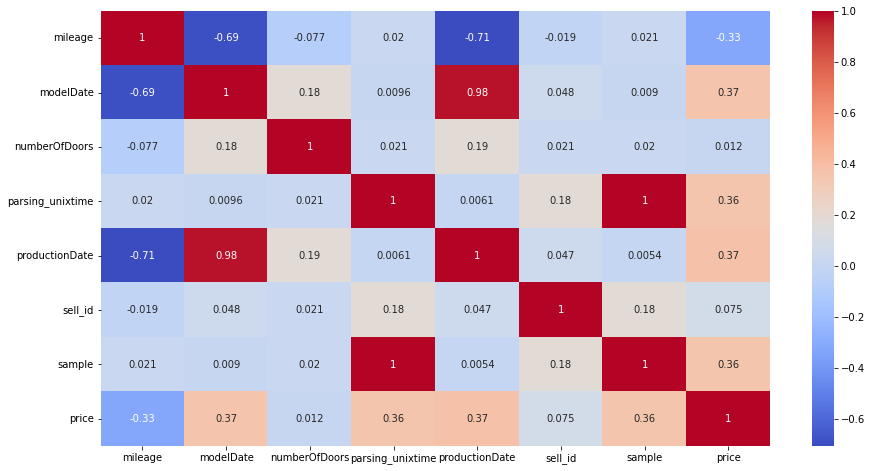

In [160]:
plt.figure(figsize=(15, 8))
correlation = df.corr()
sns.heatmap(correlation, annot = True, cmap = 'coolwarm');

По итогам анализа данных можно сделать заключение:

* Столбец bodyType: удалить информацию о количестве дверей как она есть не везде и содержится в столбце numberOfDoors; 
* Столбец brand : корректировки не требует; 
* Столбец car_url: ссылка на страницу сайта не несёт полезной информации о характеристиках автомобиля — удаляем; 
* Столбец color: корректировки не требует; 
* Столбец complectation_dict: слишком много пропусков до 79 % пропусков — удаляем; 
* Столбец description: можно попробовать создать новые столбцы с длинной описания и наличием ключевого слова «торг»; 
* Столбец engineDisplacement: содержат LTR и есть пустые значения для электромобилей, удалить «LTR», пустые заменить нулями, привести к типу переменной число с плавающей точкой; 
* Столбец enginePower: содержат N12, удалить «N12», привести к типу переменной число с плавающей точкой; 
* Столбец equipment_dict: слишком много пропусков до 30 % пропусков — удаляем; 
* Столбец fuelType: корректировки не требует; 
* Столбец image: ссылка на изображение не несёт полезной информации о характеристиках автомобиля — удаляем; 
* Столбец mileage: корректировки не требует; 
* Столбцы modelDate и productionDate сильно коррелированы, в последующем удаляем modelDate; 
* Столбец model_info: содержит данные, дублированные в других столбцах — удаляем; 
* Столбец model_name: корректировки не требует; 
* Столбец name: корректировки не требует; 
* Столбец numberOfDoors: содержит 3 значения 0 дверей — этот автомобили родстеры и кабриолет, они могутет не иметь дверей; 
* Столбец parsing_unixtime: переведём в значение datetime и используем для применения коэффициента, связанного с ростом цен между годами для поля price, после чего parsing_unixtime удалим; 
* Столбец priceCurrency: всегда содержит значение RUB — валюта продажи — удаляем; 
* Столбец sell_id: номер лота — не несёт полезной информации о характеристиках -удаляем; 
* Столбец super_gen: содержит информацию блиндированную в других столбцах — удаляем; 
* Столбец vehicleConfiguration: содержит информацию блиндированную в других столбцах — удаляем; 
* Столбец vehicleTransmission: корректировки не требует;
* Столбец vendor сильно коррелирован с столбцом brand, оставляем только один brand, vendor — удаляем; 
* Столбец ownership: содержит пустые значения, наиболее частые значения встречаются практически с равной вероятностью - замена на наиболее частое не приемлема, сочетание пустых значений и даты выпуска не содержит пустых значений, можно заменить пустые значение рассчитанной разницей в годах между датой выпуска и текущей, и наиболее частое значение до 1 года это 1 месяц, все, что до года заменим на "1 месяц". 
* Столбец owner: содержит сочетание текстовой и числовой информации, содержит несколько пустых значений. Может не быть владельца у автомобиля без пробега, однако таких нет, по дате производства автомобили старые и наиболее вероятное значение — наиболее частое «3 или более» заменим на наиболее частое. Приведем к числовому значению и к типу переменной число с плавающей точкой; 
* Столбец PTS: поскольку нет автомобилей с нулевым пробегом невозможно использовать его для создания признака «Оригинал» для автомобилей без пробега, несколько пустых можно заменить на наиболее частое; 
* Столбец gear: корректировки не требует; 
* Столбец helm: корректировки не требует;
* Столбец condition: корректировки не требует; 
* Столбец customs: пустое значение можно заменить на наиболее частое; 
* Столбец price: для приведения цен в тестовой и обучающей выборках к одному порядку цен, необходимо значения в тестовой выборке умножить на корректирующий коэффициент. Коэффициент я рассчитал следующим образом: По данным сайта https://www.autostat.ru/ за прошедший год роста цен на автомобили возраста до 7 лет составил 28%, на автомобили возраста более 7 лет 6%. По количеству автомобилей этого возраста в датасете соотношение 0.38 и 0.62 соответственно, вычислим среднее (0,280.38+0,060.62) получаем 14 % Получаем коррекционный коэффициент 1,0 — 0,14 = 0,86

# Очистка данных

Проведём выше описанные преобразования

In [161]:
# удаляем данные о количестве дверей

df['bodyType'] = df.bodyType.apply(
    lambda x: x.split()[0].strip() if isinstance(x, str) else x)

In [162]:
# Создаём новый признак - длинна описания

df['description_info'] = ''
#df['description_bargain'] = '' оказался лишним
df['description_info'] = df.description.apply(
    lambda x: len(x) if isinstance(x, str) else x)
# df['description_bargain'] = df.description.apply(
#     lambda x: 1 if (('торг' in x) or ('Торг' in x)) else 0)

In [163]:
# удаляем «LTR», пустые строки заменяем нулями

df['engineDisplacement'] = df.engineDisplacement.apply(
    lambda x: x.replace(" LTR", "0.0 LTR") if x == " LTR" else x)
df['engineDisplacement'] = df.engineDisplacement.apply(
    lambda x: float(x.replace(" LTR", "")) if isinstance(x, str) else x)
df.loc[(df['engineDisplacement'].isna()) & (
    df.fuelType == 'электро'), 'engineDisplacement'] = 0.0

In [164]:
# удаляем текст «N12» из столбца enginePower, оставляем только числовое значение

df['enginePower'] = df['enginePower'].apply(
    lambda x: float(x.replace(" N12", "")) if isinstance(x, str) else x)

In [165]:
# заменяем пустые значение рассчитанной разницей в годах между датой выпуска и текущей,
# наиболее частое значение до 1 года это 1 месяц, все, что до года заменим на "1 месяц"

df['temp_ownership'] = ''
for index, row in df.iterrows():
    temp = 2021-int(row['productionDate'])
    if temp > 0:
        df['temp_ownership'][index] = str(temp) + ' лет'
    else:
        df['temp_ownership'][index] = '1 месяц'

df['ownership'] = df['ownership'].fillna(df['temp_ownership'])
df.drop(labels=['temp_ownership'], axis=1, inplace=True)

In [166]:
# Пустые заменим на 3 и приводим все к числовому значению. 

df['owner'] = df['owner'].astype(str).apply(
    lambda x: 3 if (x.strip() == 'nan') else x)
df['owner'] = df['owner'].astype(str).apply(
    lambda x:(3 if ((x.strip() == '3 или более') or (x.strip() == '3\xa0или\xa0более')) else
    (2 if ((x.strip() == '2 владельца') or (x.strip() == '2\xa0владельца')) else 
    (1 if ((x.strip() == '1 владелец') or (x.strip() == '1\xa0владелец')) else x))))
df['owner'] = df['owner'].astype(str).apply(
    lambda x: 3 if (x.strip() == 'nan') else x)

In [167]:
# Заменяем пустые значения на 'Оригинал'

df['PTS'] = df['PTS'].astype(str).apply(
    lambda x: 'Оригинал' if x.strip() == 'nan' else x)

In [168]:
# Заменяем пустые значения на 'Растаможен'

df.customs = df.customs.astype(str).apply(
    lambda x: 'Растаможен' if x.strip() == 'nan' else x)

In [169]:
# приведём parsing_unixtime к формату datetime

df['parsing_date'] = ''
df['parsing_date'] = pd.to_datetime(df.parsing_unixtime, unit='s')
df['parsing_date'] = pd.to_datetime(df.parsing_date.dt.floor('d'))

In [170]:
# по объявлениям 2021 года (тестовый датасет за 2020 год) 
# умножим 'price' на коэффициент 0.86

for index, row in df.iterrows():
    if row['parsing_date'].year == 2021:
        df['price'][index] = df['price'][index] * 0.86

In [171]:
# удалим пустые значения в столбце 'price'

df = df.dropna(subset=['price'])

In [172]:
df['customs'] = df['customs'].apply(lambda x: 1 if x == True else 0)

In [173]:
df['condition'] = df['condition'].apply(
    lambda x: 0 if x == "Не требует ремонта" else 1)

In [174]:
# удалим ненужные столбцы

df.drop(labels=['car_url', 'complectation_dict', 'description', 'equipment_dict', 'image',
                'model_info', 'parsing_unixtime', 'priceCurrency', 'sell_id',
                'super_gen', 'vehicleConfiguration', 'vendor'], axis=1, inplace=True)

In [175]:
df.isnull().sum()

bodyType               0
brand                  0
color                  0
engineDisplacement     0
enginePower            0
fuelType               0
mileage                0
modelDate              0
model_name             0
name                   0
numberOfDoors          0
productionDate         0
vehicleTransmission    0
owner                  0
ownership              0
PTS                    0
gear                   0
helm                   0
condition              0
customs                0
sample                 0
price                  0
description_info       0
parsing_date           0
dtype: int64

Пустых значений не оталось, проанализируем структур получившегося датасета

In [176]:
#pandas_profiling.ProfileReport(df)

* Набор данных состоит из 24 объектов и 117125 наблюдений; 
* Пропущенных значений нет; 
* Дубликатов нет; 
* Существует сильная корреляция между: engineDisplacement и enginePower
 учтём это в дальнейшем


# Разведовательный анализ данных

сгруппируем столбцы по типам

In [177]:
# категориальные признаки
cat_cols = ['bodyType', 'brand', 'color', 'fuelType', 'model_name',
            'name', 'gear', 'ownership', 'owner', 'vehicleTransmission',
            'numberOfDoors']
#числовые признаки
num_cols = ['engineDisplacement', 'enginePower',
            'mileage', 'productionDate', 'description_info']
# бинарные признаки
bin_cols = ['condition', 'customs', 'helm', 'PTS']
# вспомогательные признаки
help_cols = ['sample', 'parsing_date']
# целевая переменная
target_cols = ['price']

all_cols = cat_cols + num_cols + bin_cols + help_cols + target_cols
len(all_cols)

23

Анализ числовых столбцов: распределение, корреляция, выбросы

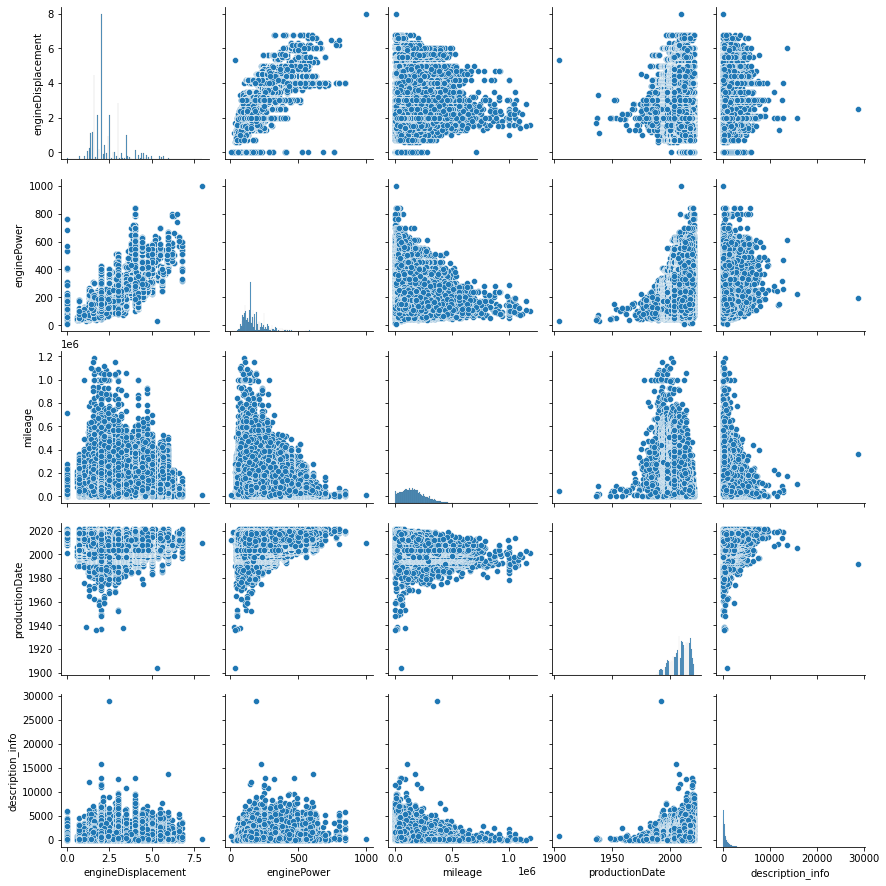

In [178]:
sns.pairplot(df[num_cols])

Сильно скоррелированных распределений нет, однако нет и нормального распределенных признаков, распределение смещено в той или иной мере в право или влево. Нужно проверить как повлияет логарифмирование на характер распределения.

In [179]:
df[num_cols].describe()

,engineDisplacement,enginePower,mileage,productionDate,description_info
count,117125.000000,117125.000000,1.171250e+05,117125.000000,117125.000000
mean,2.322051,177.712094,1.663488e+05,2009.261891,677.201264
std,0.933179,86.910829,1.106092e+05,7.646504,773.864636
min,0.000000,7.000000,1.000000e+00,1904.000000,1.000000
25%,1.600000,116.000000,8.400000e+04,2004.000000,165.000000
50%,2.000000,151.000000,1.512300e+05,2010.000000,389.000000
75%,2.800000,211.000000,2.300000e+05,2015.000000,946.000000
max,8.000000,1001.000000,1.190000e+06,2021.000000,28789.000000


Статистические данные подтверждают большой разброс значений и смещение данных, не исключены выбросы, может потребоваться нормализация. 

In [180]:
# создадим датафрейм для анализа влияния логарифмирования на 
# характер распределения признаков

data = pd.DataFrame()
data['price']=df['price']

<Figure size 432x288 with 0 Axes>

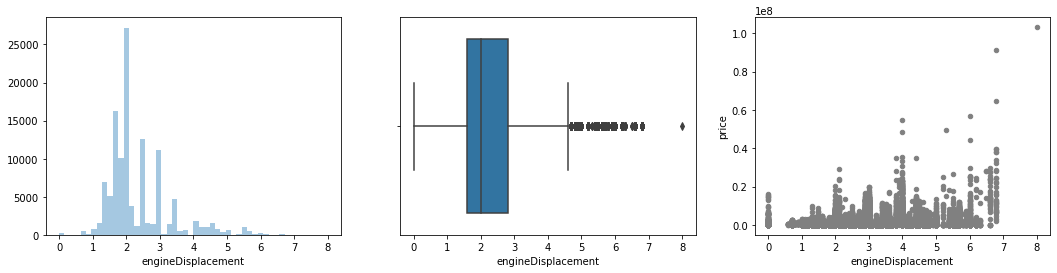

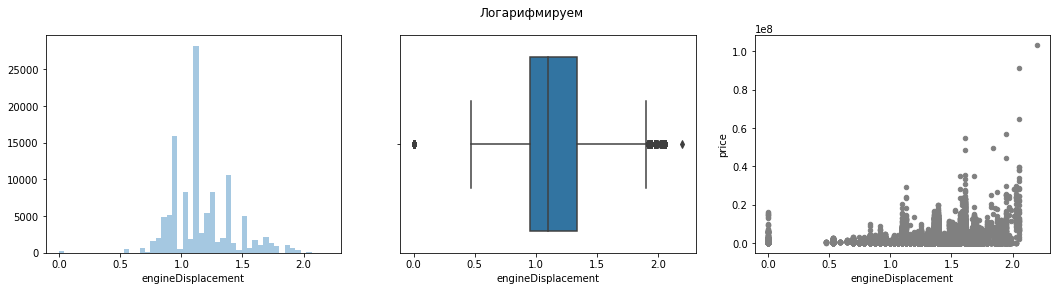

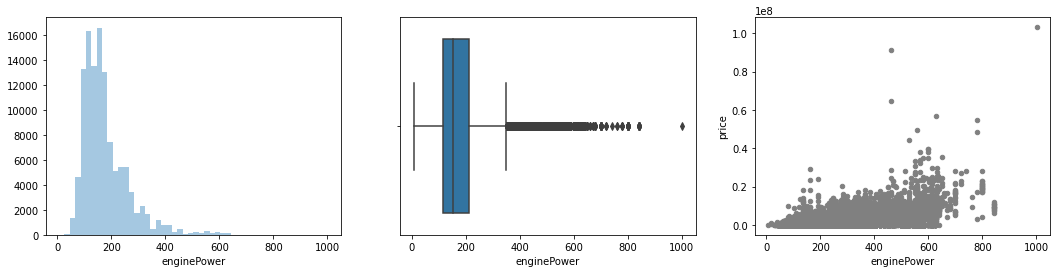

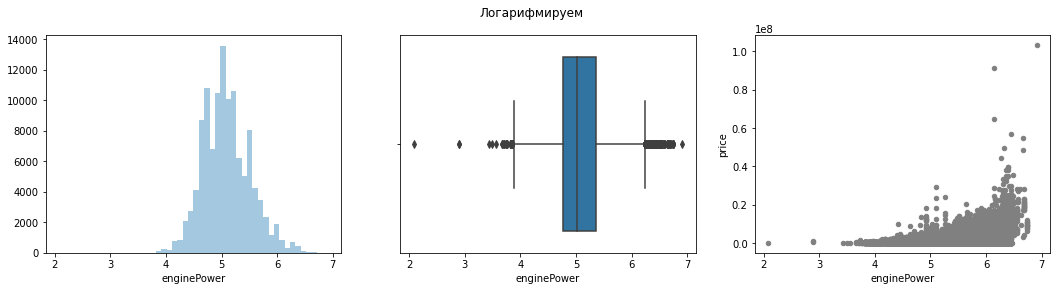

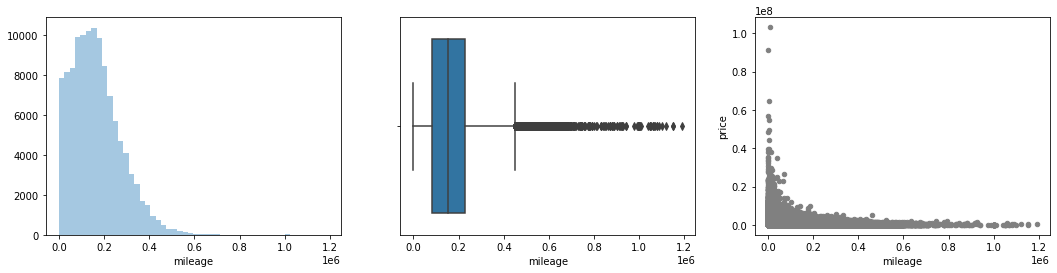

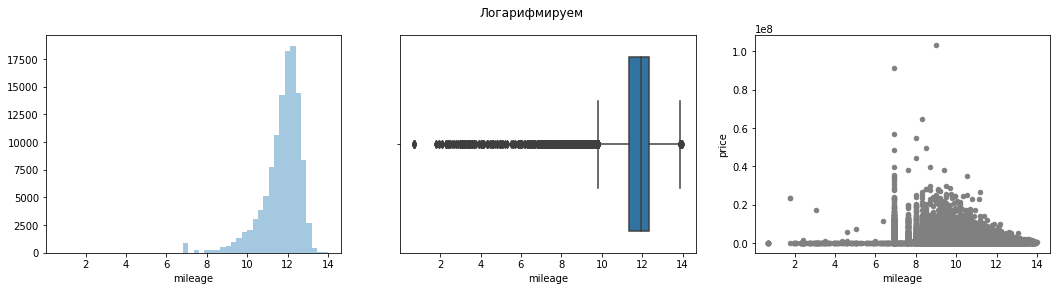

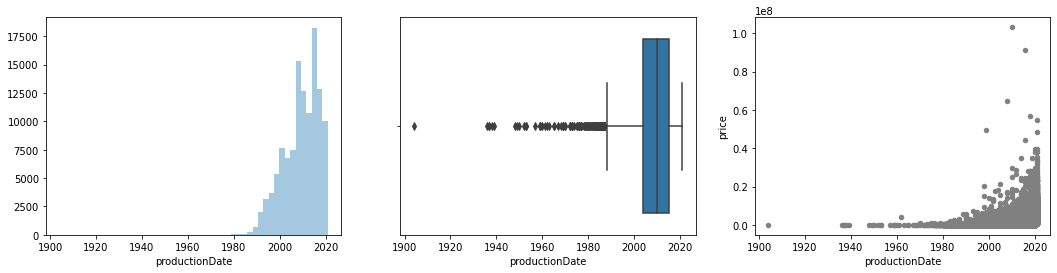

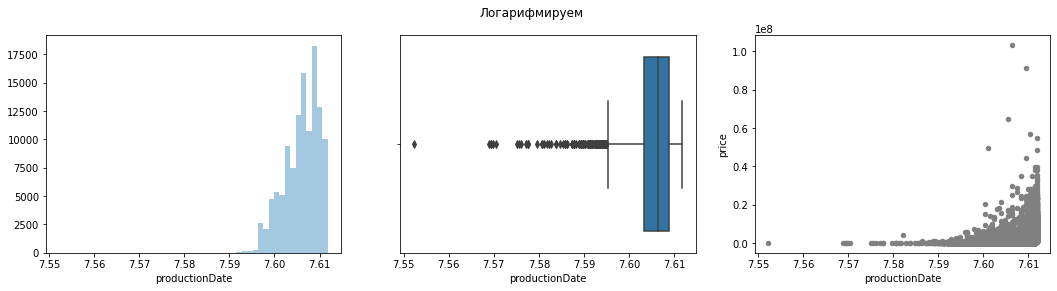

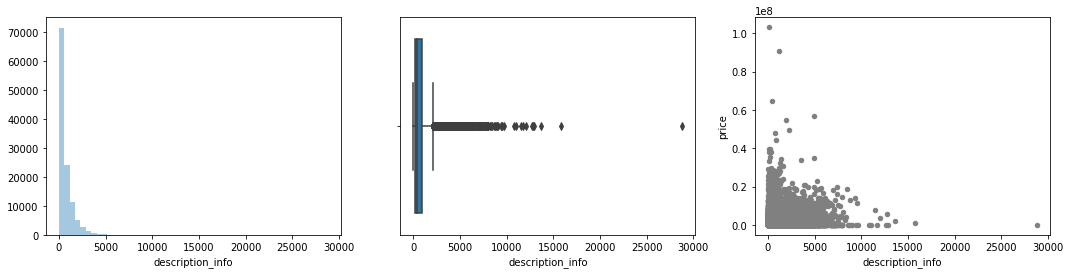

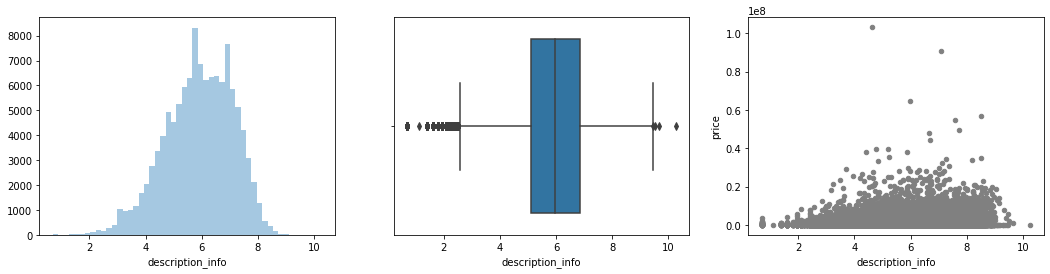

In [181]:
# построим сравнительные графики без логарифмирования и после логарифмирования

for item in num_cols:
    plt.suptitle('Логарифмируем')
    fig, ax =plt.subplots(1,3, figsize=(18,4))
    sns.distplot(df[item].dropna(), kde = False, rug=False, ax=ax[0])
    sns.boxplot(df[item], ax=ax[1])
    df.plot(x = item, y = 'price', kind = 'scatter',color="0.5", ax=ax[2])
    fig.show()
    
    data[item] = df[item].apply(lambda w: np.log(w + 1))
    fig, ax =plt.subplots(1,3, figsize=(18,4))
    sns.distplot(data[item].dropna(), kde = False, rug=False, ax=ax[0])
    sns.boxplot(data[item], ax=ax[1])
    data.plot(x = item, y = 'price', kind = 'scatter',color="0.5", ax=ax[2])
    fig.show()

Логарифмирование даёт хороший результат результат на enginePower, mileage, description_info - прологарифмируем их. 
Однако это не устранило вбросы. Проведем дополнителный анализ признаков в разрезе тренировочной и тестовой выборок.

Оценим корреляцию признаков

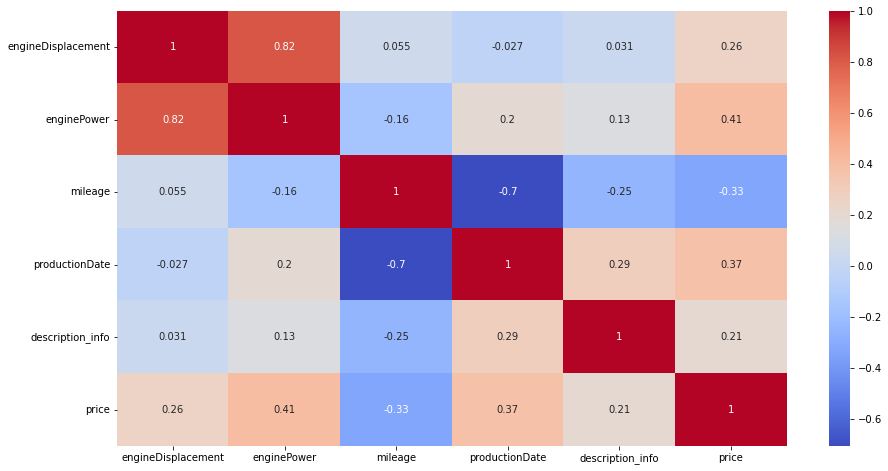

In [182]:

plt.figure(figsize=(15, 8))
correlation = df[num_cols + ['price']].corr()
sns.heatmap(correlation, annot = True, cmap = 'coolwarm');

Высокая корреляция параметров enginePower и engineDisplacement - 0,82 поскольку корреляция с целевой переменной лучше у enginePower оставим ее, удалим engineDisplacement.

In [183]:
# удаляем 'engineDisplacement'

df.drop(labels=['engineDisplacement'], axis=1, inplace=True)

Посмотрим детальнее на оставшиеся переменные

In [184]:
# сравним статистические показатели столбца enginePower 
# в обучающей и тестовой выборках

df.query('sample == 1').enginePower.describe(), df.query('sample == 0').enginePower.describe()

(count    82439.000000
 mean       173.301799
 std         85.596475
 min          7.000000
 25%        115.000000
 50%        150.000000
 75%        204.000000
 max       1001.000000
 Name: enginePower, dtype: float64, count    34686.000000
 mean       188.194142
 std         89.087035
 min         30.000000
 25%        125.000000
 50%        169.000000
 75%        233.000000
 max        639.000000
 Name: enginePower, dtype: float64)

In [185]:
# посмотрим на автомобили с двигателем мощнее 639 лошадиных сил

df[df.enginePower > 639] 

,bodyType,brand,color,enginePower,fuelType,mileage,modelDate,model_name,name,numberOfDoors,productionDate,vehicleTransmission,owner,ownership,PTS,gear,helm,condition,customs,sample,price,description_info,parsing_date
35451,внедорожник,PORSCHE,красный,680.0,гибрид,4000.0,2019.0,Cayenne Coupe,Turbo S E-Hybrid 4.0hyb AT (680 л.с.) 4WD,5.0,2021.0,автоматическая,1,9 месяцев,Оригинал,полный,Левый,0,0,1,10483400.0,255,2021-11-11
35571,внедорожник,MERCEDES,серый,800.0,бензин,3000.0,2018.0,G-Класс AMG,Brabus 800 4.0 AT (800 л.с.) 4WD,5.0,2021.0,автоматическая,1,1 месяц,Оригинал,полный,Левый,0,0,1,18834000.0,1641,2021-11-11
36869,внедорожник,MERCEDES,чёрный,700.0,бензин,28000.0,2018.0,G-Класс AMG,Brabus 700 4.0 AT (700 л.с.) 4WD,5.0,2018.0,автоматическая,2,3 лет,Оригинал,полный,Левый,0,0,1,14413600.0,837,2021-11-11
36953,внедорожник,PORSCHE,серый,680.0,гибрид,4000.0,2019.0,Cayenne Coupe,Turbo S E-Hybrid 4.0hyb AT (680 л.с.) 4WD,5.0,2020.0,автоматическая,2,1 лет,Оригинал,полный,Левый,0,0,1,8428000.0,2617,2021-11-11
38032,внедорожник,MERCEDES,чёрный,800.0,бензин,4000.0,2018.0,G-Класс AMG,Brabus 800 4.0 AT (800 л.с.) 4WD,5.0,2020.0,автоматическая,1,1 лет,Оригинал,полный,Левый,0,0,1,21147400.0,832,2021-11-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119123,внедорожник,MERCEDES,чёрный,700.0,бензин,21000.0,2018.0,G-Класс AMG,Brabus 700 4.0 AT (700 л.с.) 4WD,5.0,2019.0,автоматическая,1,2 лет,Оригинал,полный,Левый,0,0,1,17036600.0,3684,2021-11-12
119151,внедорожник,LAMBORGHINI,серый,650.0,бензин,27000.0,2017.0,Urus,4.0 AT (650 л.с.) 4WD,5.0,2018.0,автоматическая,3,2 года и 11 месяцев,Оригинал,полный,Левый,0,0,1,20339000.0,221,2021-11-12
119322,внедорожник,MERCEDES,синий,700.0,бензин,30000.0,2018.0,G-Класс AMG,Brabus 700 4.0 AT (700 л.с.) 4WD,5.0,2018.0,автоматическая,1,3 года,Оригинал,полный,Левый,0,0,1,14086800.0,72,2021-11-12
119461,внедорожник,MERCEDES,чёрный,700.0,бензин,166000.0,2012.0,G-Класс AMG,Brabus 700 5.5 AT (700 л.с.) 4WD,5.0,2012.0,автоматическая,1,8 лет и 11 месяцев,Оригинал,полный,Левый,0,0,1,5538400.0,187,2021-11-12


В обучающей выборке значения большие чем в тестовой. Однако по характеристикам автомобилей похожи на реальные, топовые автомобили имеют мощные двигатели, оставляем без изменений.

In [186]:
# сравним статистические показатели столбца mileage 
# в обучающей и тестовой выборках

df.query('sample == 1').mileage.describe(), df.query('sample == 0').mileage.describe()

(count    8.243900e+04
 mean     1.681744e+05
 std      1.144826e+05
 min      5.000000e+00
 25%      8.000000e+04
 50%      1.530000e+05
 75%      2.360000e+05
 max      1.190000e+06
 Name: mileage, dtype: float64, count      34686.000000
 mean      162009.767889
 std       100676.559489
 min            1.000000
 25%        91153.500000
 50%       149779.500000
 75%       215000.000000
 max      1000000.000000
 Name: mileage, dtype: float64)

Распределения в тестовой и обучающей выборках близки, но есть большой хвост,
необходимо сопоставить пробег с ценой и годом производства

(0.0, 1200.0)

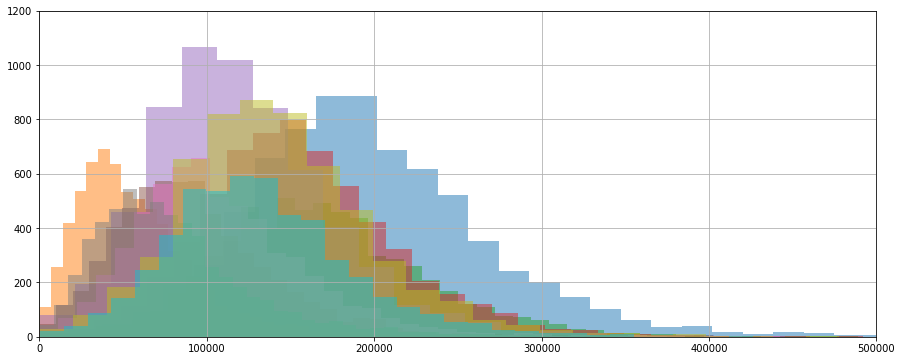

In [187]:
# посмотрим на топ 10 
plt.figure(figsize=(15, 6))
for year in df['productionDate'].value_counts().index[:10]:
    df[df['productionDate'] == year].mileage.hist(bins=50, alpha=0.5)
plt.xlim(0, 500000)
plt.ylim(0, 1200)

Распеределение практически нормальное для каждого варианта, а значит можно создать дополнительный параметр - ежегодный пробег. 

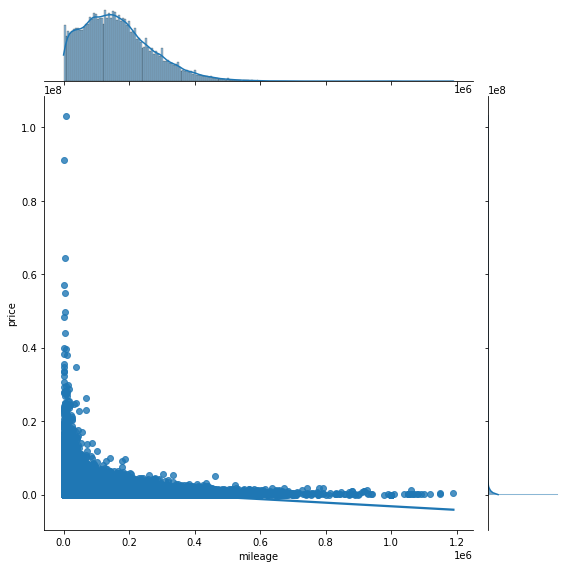

In [188]:
# сопоставим цену с пробегом

sns.jointplot(x='mileage', y='price', data=df, kind='reg', height=8)

явной зависисмости снижения цены от роста пробега нет, зависимсость более сложная.

 в обучающей выборки все автомобили произведены позже 1960 года, посмотрим сколько произведённых ранее в тестовой

In [189]:
len(df[df['productionDate'] < 1960])

16

Количество не значительно, корректировать не будем

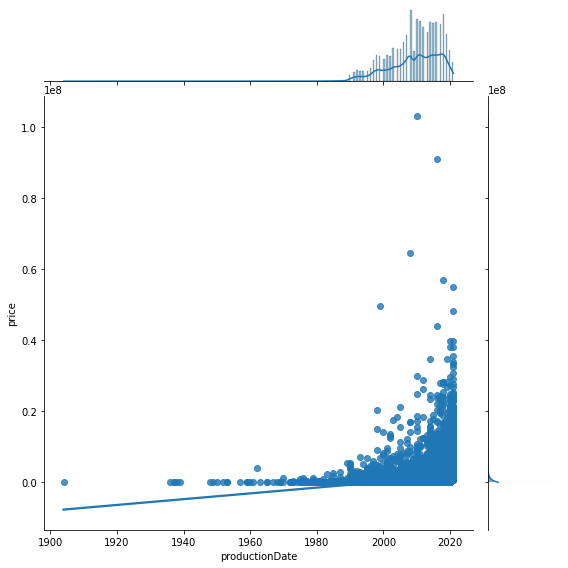

In [190]:
# сопоставим цену с датой производства

sns.jointplot(x='productionDate', y='price', data=df, kind='reg', height=8)

Снижение цены имеет плато в районе 3-5 лет далее зависимость от возраста практически линейна. Можно использовать как временную границу для новых признаков.

Проанализируем категориальные и бинаные признаки

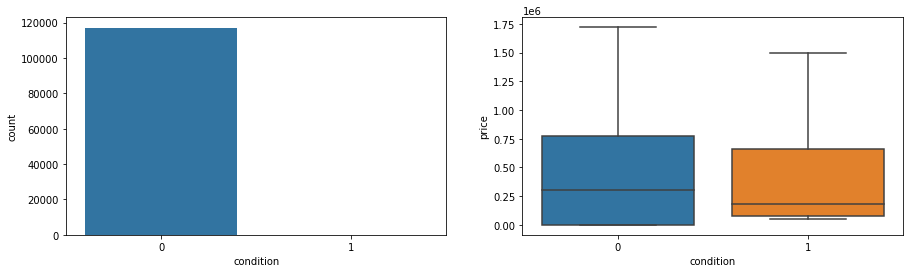

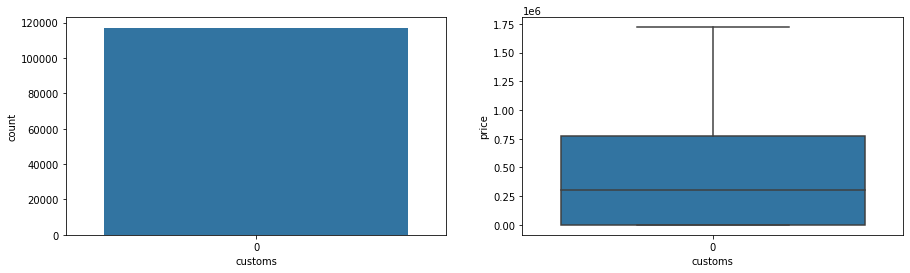

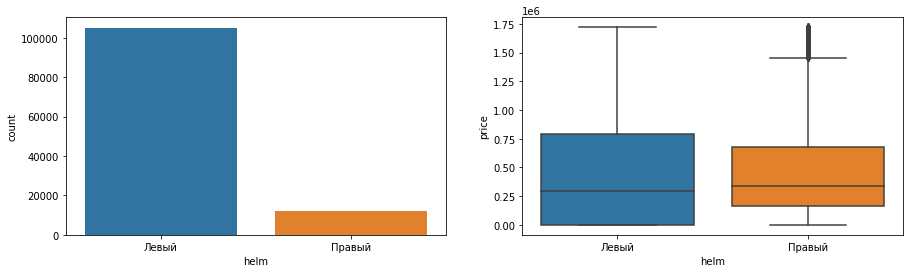

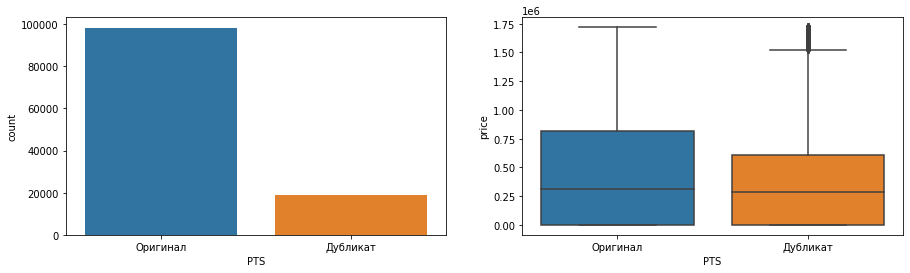

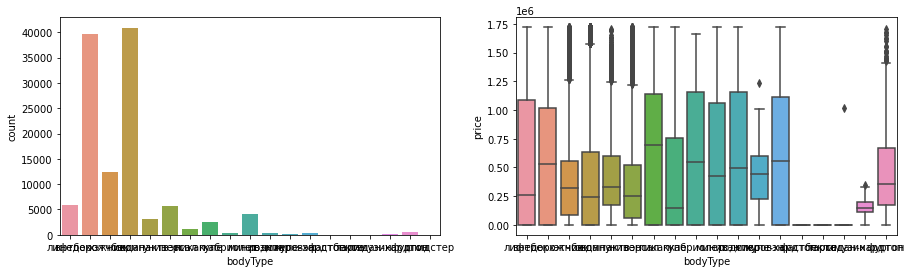

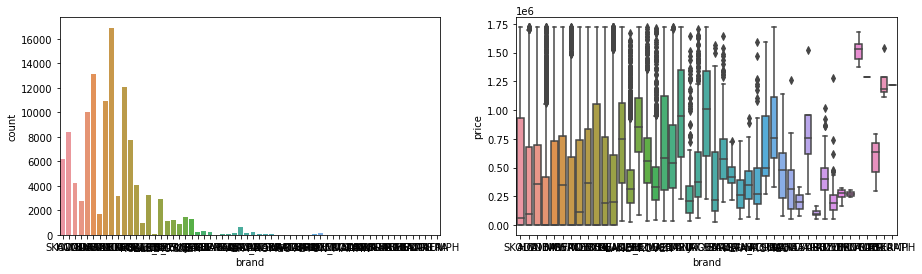

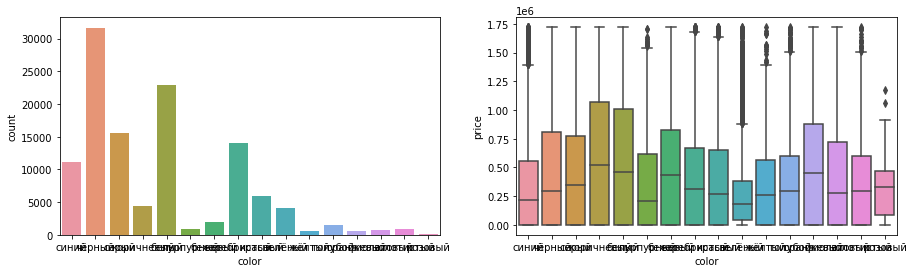

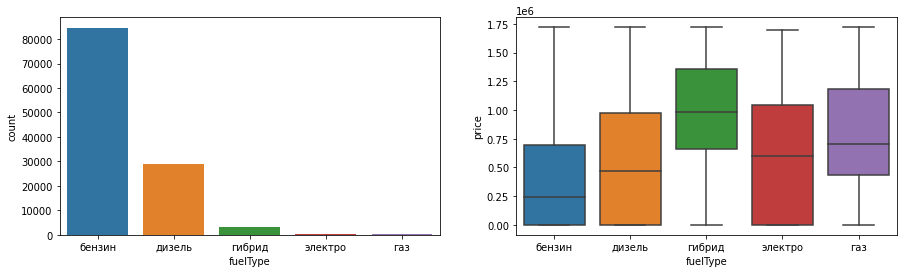

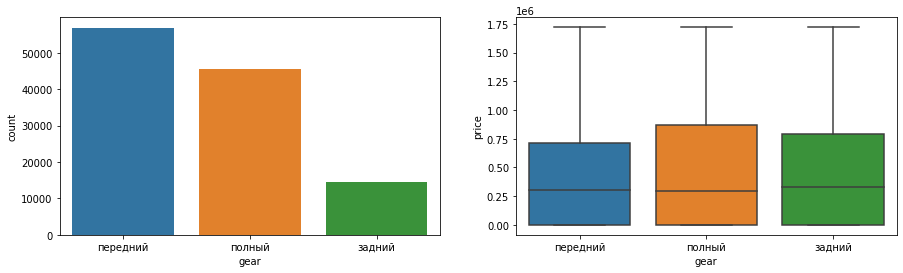

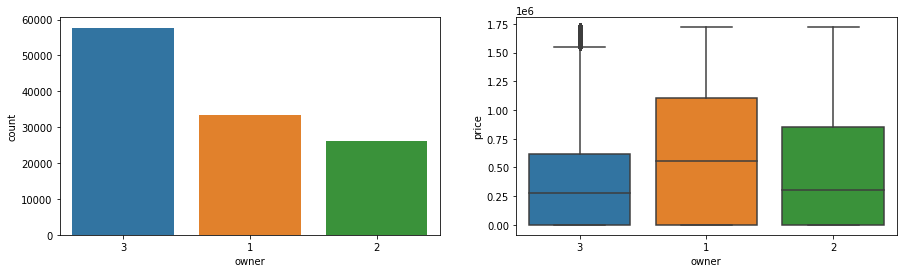

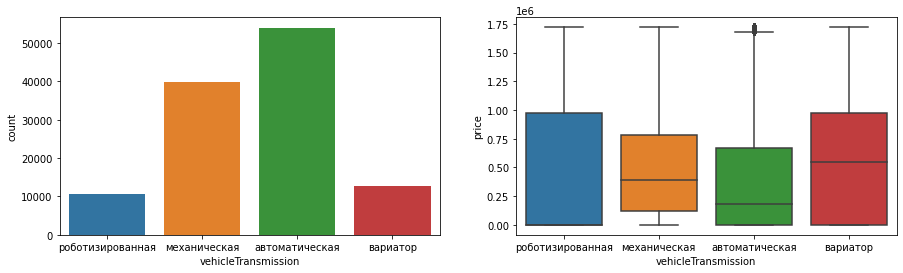

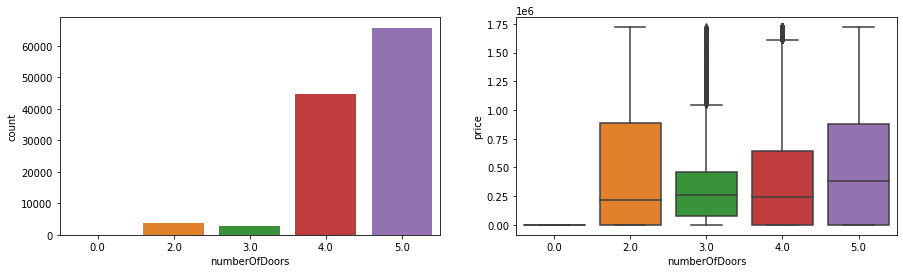

In [191]:
for item in bin_cols + cat_cols:  
    if item not in ['model_name', 'name', 'ownership']: 
        # слишком много значений в этих колонках перегрузят график, сделав его не информативным
        fig, ax =plt.subplots(1,2, figsize=(15,4))
        sns.countplot(x = item, data = df, ax=ax[0])
        # для наглядности анализа распределения цены для значений 
        # признака уберём хвосты задав quantile(0.85)
        sns.boxplot(x=item, y='price', data=df[df['price'] <= df['price'].quantile(0.85)], ax=ax[1])
        fig.show()

В целом признаки не сбалансированы, рассмотрим их детальнее:

* Столбец helm:  «Левый» встречается примерно в 90-95% случаев, цены сбалансированы;
* Столбец PTS:  около 80%  оригиналов и цены на автомобили с оригиналом выше. 
* description_bargain: частота признака без торга около 70% и цены на эти автомобили выше.
* Столбец bodyType: наиболее распространенных значения - это «внедорожник» , «седан» до 30% и «хэтчбек до 10%. Но на распределение цен частота не влияет;
* Столбец brand: здесь мы можем увидеть распределение брендов, представленных в наборе данных. Цены существенно различаются, причём на редкие бренды цены выше;
* столбец color: кореляции частот цветов и цен не наблюдается, однако есть корреляция определенных цветов и цены,  можно попробовать создать новый столбец;
* Столбец fuelType: Самым частым является «бензин» около 70% , но «дизель», а особенно «гибрид» стоит дороже;
* Столбец gear: Преобладает передний привод, за тем полный и задний, цена ожидаемо больше на полный;
* Столбец owner: Между количеством собственников и ценой существует линейная зависимость. 
* Столбец vehicleTransmission: «Автомат» встречается примерно в 60% случаев. Наибольшая цена на автомобили с вариатором;
* Столбец numberOfDoors: наиболее часто встречаются  автомобили с 5 дверями. 2 и 5 дверные сопоставимы по цене.  Самые дешевые автомобили с 3 дверьми. Можно попробовать создать новый признак.
* Столбцы model, model_name и ownership мы не отображали их на графиках, потому что там слишком много категорий.

Признаки condition и customs содержат соответственно почти все значения «Битый / не на ходу» и «не растоможен», а значит смысла не имеют (практически все значения одинаковы) — нужно удалить.

In [192]:
# удаляем condition и customs

df.drop(labels=['condition', 'customs'], axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)

Анализ целевой переменной

Text(0.5, 0, 'price, RUB * 10^7')

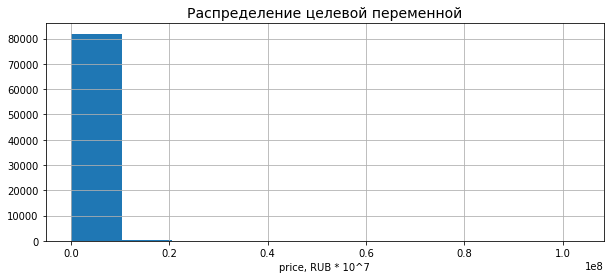

In [193]:
df.query('sample == 1').price.hist(figsize=(10, 4))
plt.title('Распределение целевой переменной', fontdict={'fontsize': 14})
plt.xlabel('price, RUB * 10^7')

распределение не нормальное, попробуем логарифмирование

Text(0.5, 1.0, 'Логарифмированная целевая переменная')

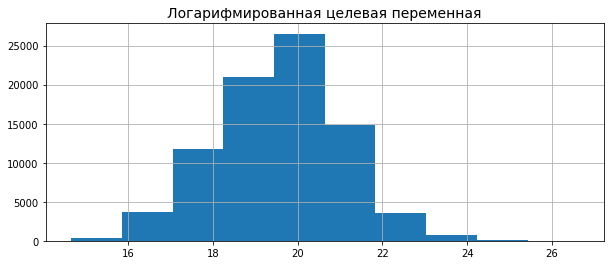

In [194]:
np.log2(df.query('sample == 1').price).hist(figsize=(10, 4))
plt.title('Логарифмированная целевая переменная', fontdict={'fontsize': 14})

Распределение стало почти нормальным, создадим логарифмированный столбец.

In [195]:
# проведем логарифмирование столбцов price_log, enginePower, mileage, description_info

df['price_log'] = np.log2(df['price'] + 1)
df['enginePower'] = np.log2(df['enginePower'] + 1)
df['mileage'] = np.log2(df['mileage'] + 1)
df['description_info'] = np.log2(df['description_info'] + 1)

# Создание новых признаков

Создадим следующие признаки:

* miles_in_year: на основании столбцов productionDate и mighting создадим столбез с пробегом за год;
* age_car: возраст автомобиля;
* age_model: разница в годах между началом выпуска модели и выпуском автомобиля;
* old_3: старше ли авто 3 лет;
* old_5: старше ли авто 5 лет;
* top_bodyType: есть ли у автомобиля тип кузова «внедорожник» и «седан»;
* rare_bodyType: есть ли у автомобиля редкий тип кузова: «микровэн», «седан-хардтоп», «лимузин», «тарга», «фастбек»;
* top_colors: есть ли в авто топ5 цветов: черный, белый, серый, синий, серебристый;
* min_colors: есть ли у авто редкие цвета: 'фиолетовый', 'пурпурный', 'золотистый', 'оранжевый', 'жёлтый', 'розовый';
* top_door_num: у машины 4 или 5 дверей;

In [196]:
# создание признаков
# сгруппируем новые признаки в списки
# числовые

new_cols_num = ['miles_in_year', 'age_car',
                'age_model']
df['age_car'] = 2021 - df.productionDate
df['miles_in_year'] = df['mileage']/df['age_car']
df['miles_in_year'].replace([np.inf, -np.inf], 0, inplace=True)
df['age_car'].replace([np.inf, -np.inf], 0, inplace=True)
df['age_model'] = df['productionDate'] - df['modelDate']
df.loc[df['age_model'] < 0, 'age_model'] = 0

# бинарные
new_cols_bin = ['old_3', 'old_5', 'top_bodyType',
                'rare_bodyType', 'top_colors', 'rare_colors', 'top_door_num']
df['old_3'] = df['productionDate'].apply(lambda x: 1 if x < 2021 - 3 else 0)
df['old_5'] = df['productionDate'].apply(lambda x: 1 if x < 2021 - 5 else 0)
df['top_bodyType'] = df['bodyType'].apply(
    lambda x: 1 if x in ['внедорожник', 'седан'] else 0)
df['rare_bodyType'] = df.bodyType.apply(lambda x: 1 if x in [
                                        'микровэн', 'седан-хардтоп', 'лимузин', 'тарга',
                                        'фастбек', 'спидстер'] else 0)
df['top_colors'] = df.color.apply(
    lambda x: 1 if x in ['черный', 'белый', 'серый', 'синий', 'серебристый'] else 0)
df['rare_colors'] = df.color.apply(lambda x: 1 if x in [
                                   'фиолетовый', 'пурпурный', 'золотистый', 'оранжевый',
                                   'жёлтый', 'розовый'] else 0)
df['top_door_num'] = df.numberOfDoors.apply(lambda x: 1 if x in [4, 5] else 0)

оценим влияние логарифмирования на новые признаки

<Figure size 432x288 with 0 Axes>

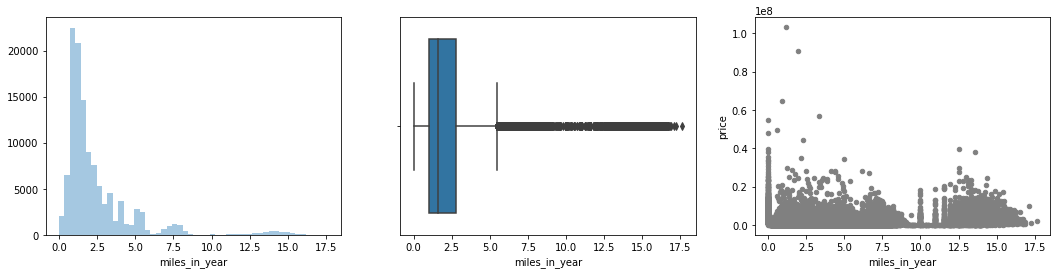

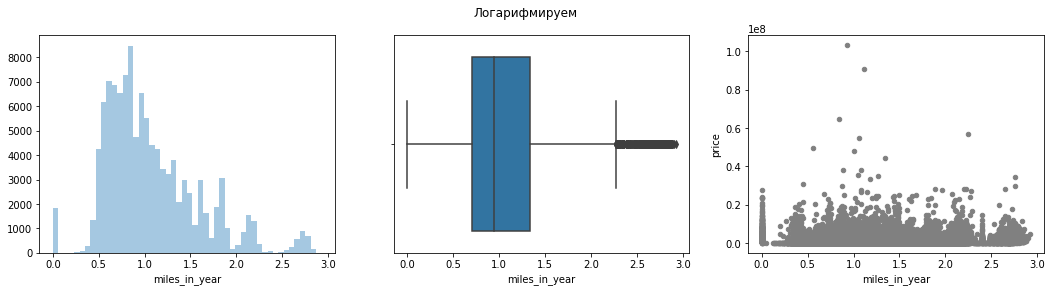

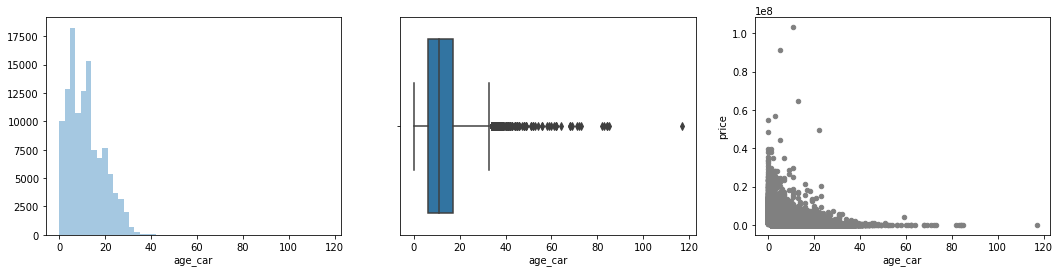

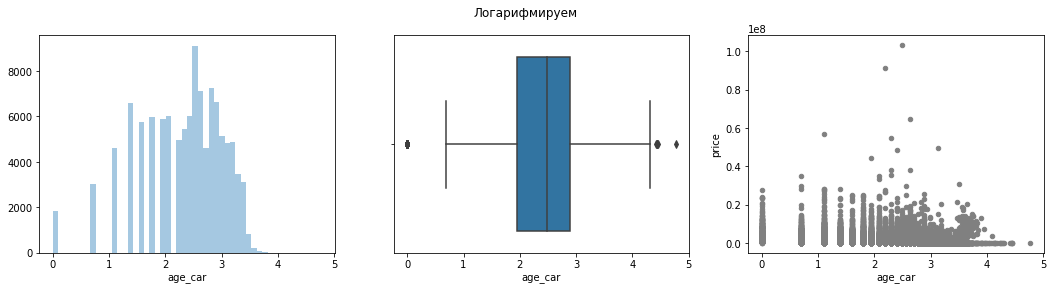

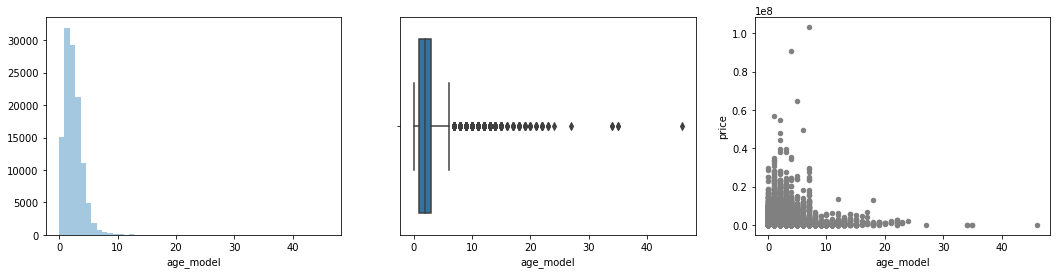

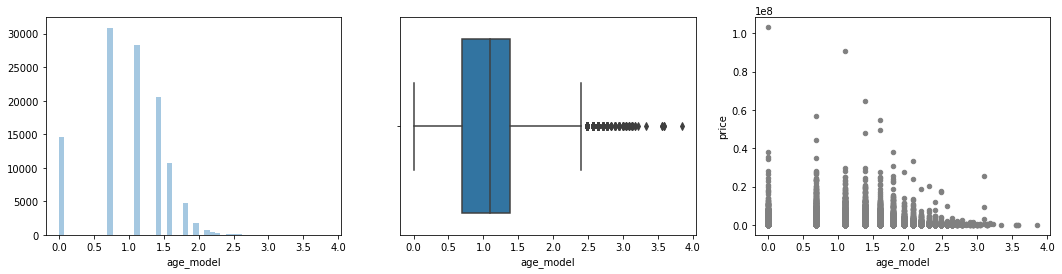

In [197]:
for item in new_cols_num:
    plt.suptitle('Логарифмируем')
    fig, ax = plt.subplots(1, 3, figsize=(18, 4))
    sns.distplot(df[item].dropna(), kde=False, rug=False, ax=ax[0])
    sns.boxplot(df[item], ax=ax[1])
    df.plot(x=item, y='price', kind='scatter', color="0.5", ax=ax[2])
    fig.show()

    data[item] = df[item].apply(lambda w: np.log(w + 1))
    fig, ax = plt.subplots(1, 3, figsize=(18, 4))
    sns.distplot(data[item].dropna(), kde=False, rug=False, ax=ax[0])
    sns.boxplot(data[item], ax=ax[1])
    data.plot(x=item, y='price', kind='scatter', color="0.5", ax=ax[2])

Логарифмирование несколько улучшает рпспределение признаков, проведем логарифмирование

In [198]:
# логарифмируем признаки miles_in_year, age_car, age_model

df['miles_in_year'] = np.log2(df['miles_in_year']+1)
df['age_car'] = np.log2(df['age_car']+1)
df['age_model'] = np.log2(df['age_model']+1)

Оценим корреляцию новых признаков

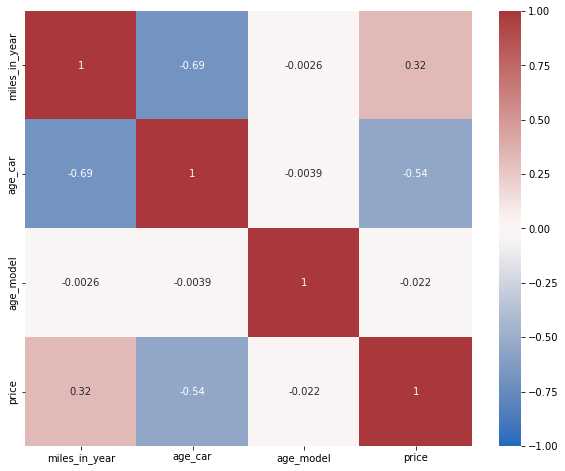

In [199]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[df['sample'] == 1][new_cols_num + ['price']
                                  ].corr(), vmin=-1, vmax=1, annot=True, cmap='vlag')

Результат преобразований удовлетворительный.

Проанализируем бинарные признаки

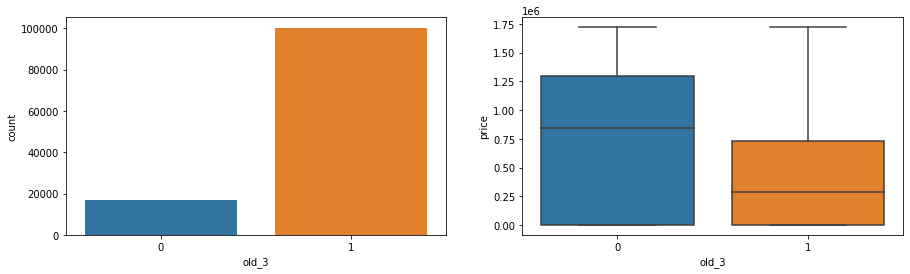

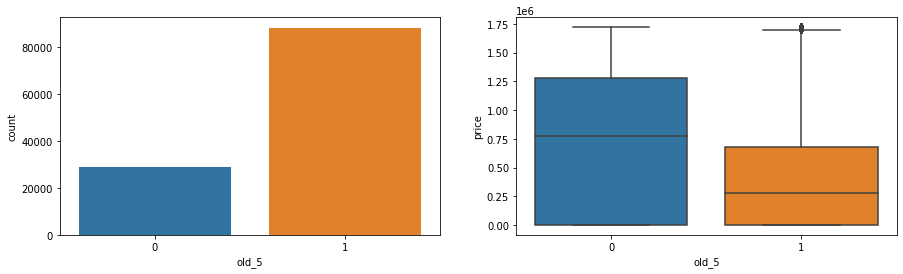

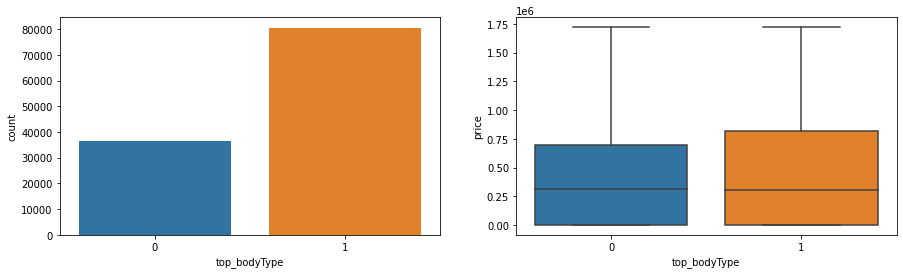

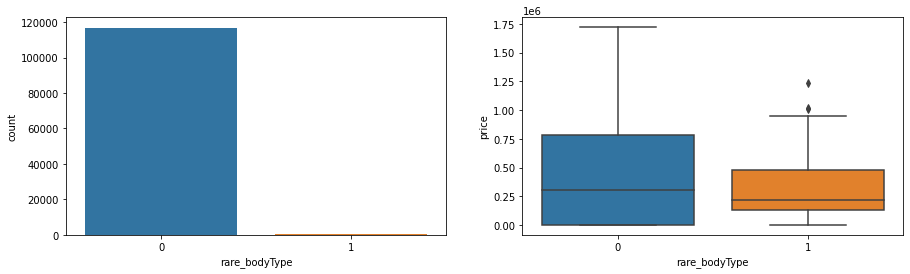

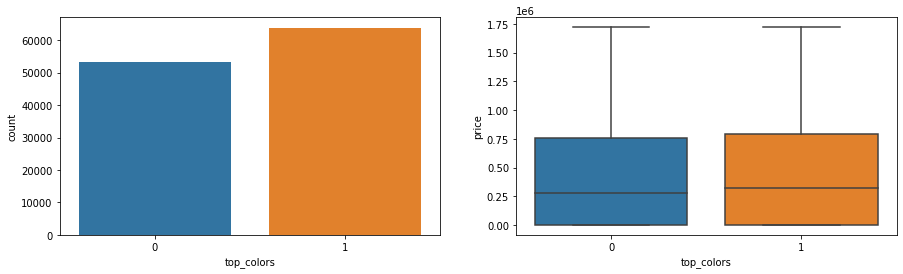

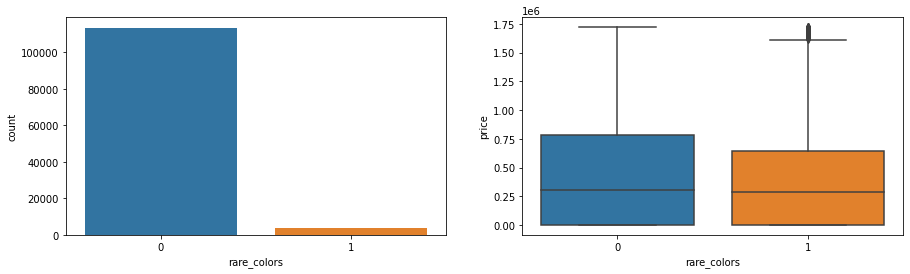

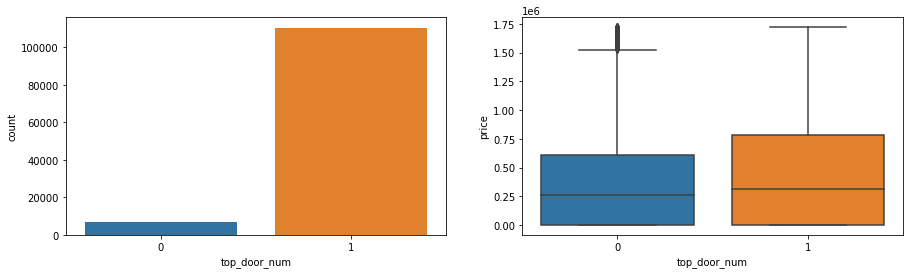

In [200]:
for item in new_cols_bin:
    fig, ax = plt.subplots(1, 2, figsize=(15, 4))
    sns.countplot(x=item, data=df, ax=ax[0])
    # для наглядности анализа распределения цены для значений признака уберём хвосты
    # задав quantile(0.85)
    sns.boxplot(x=item, y='price',
                data=df[df['price'] <= df['price'].quantile(0.85)], ax=ax[1])
    fig.show()

По графикам дисбаланса нет, новые признаки могут быть полезными.

In [201]:
# удалим productionDate

df.drop(labels=['productionDate'], axis=1, inplace=True)

Оценим важность числовых признаков

Text(0.5, 0, 'f статистика')

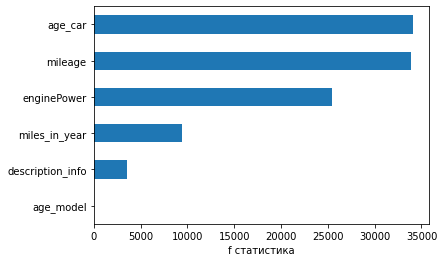

In [202]:
num_cols = ['enginePower', 'mileage', 'description_info'] + new_cols_num
imp_num = pd.Series(f_regression(
    df[df['sample'] == 1][num_cols], df[df['sample'] == 1]['price'])[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')
plt.xlabel('f статистика')

Наиболее важными являются признаки age_car и mileage .

In [203]:
# обрабатываем категориальные переменные

for colum in ['helm', 'vehicleTransmission', 'brand', 'PTS']:
    df[colum] = df[colum].astype('category').cat.codes

cols_to_encode = list(set(df.columns) & set(cat_cols))
for colum in cols_to_encode:
    df[colum] = df[colum].astype('category').cat.codes

Оценим важность категориальных признаков

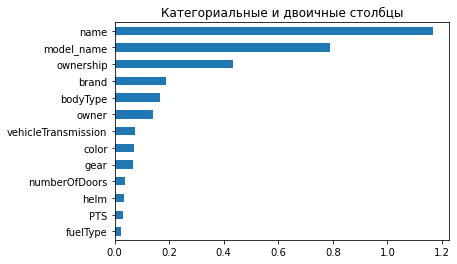

In [204]:
imp_cat = pd.Series(
    mutual_info_regression(
        df[df['sample'] == 1][list(set(df.columns) & set(cat_cols+bin_cols))], 
        df[df['sample'] == 1]['price'], 
        discrete_features=True), index=list(set(df.columns) & set(cat_cols+bin_cols))
)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh', title='Категориальные и двоичные столбцы')
plt.show()

наиболее значимы name, model_name, ownership

# Machine learning

In [205]:
# перестроим индексы в датасете
df = df.reindex()

In [206]:
# разделяем тестовую и обучающую выборки

X = df.query('sample == 1').drop(['price', 'sample', 'parsing_date',   'price_log'
                                  ], axis=1).reset_index(drop=True)
X_sub = df.query('sample == 0').drop(['price', 'sample', 'parsing_date',  'price_log'
                                      ], axis=1)
y = df.query('sample == 1').price.reset_index(drop=True)

In [207]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

In [208]:
# расчёт метрики

def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)/y_true))

## Создадим "наивную" модель

Эта модель будет предсказывать среднюю цену по модели двигателя (engineDisplacement). C ней будем сравнивать другие модели.

In [209]:
tmp_train = X_train.copy()
tmp_train['price'] = y_train

In [210]:
# Находим median по экземплярам mileage в трейне и размечаем тест
predict = X_test['enginePower'].map(
    tmp_train.groupby('enginePower')['price'].median())

# оцениваем точность
print(
    f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")

Точность наивной модели по метрике MAPE: nan%


## 1. CatBoostRegressor

In [211]:
# задаем параметры модели
# model = CatBoostRegressor(iterations = 5000,
#                           random_seed = RANDOM_SEED,
#                           eval_metric='MAPE',
#                           custom_metric=['R2', 'MAE'],
#                           silent=True,
#                         )
# проводим обучение
# model.fit(X_train, y_train,
#           eval_set=(X_test, y_test),
#           verbose_eval=0,
#           use_best_model=True,
#          )

# model.save_model('catboost_single_model_baseline.model')

# оцениваем точность
# predict = model.predict(X_test)
# print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

получаем Точность модели по метрике MAPE: 21.00%

Попробуем предварительно стандартизировать данные

In [212]:
# scaler = StandardScaler()
# X = scaler.fit_transform(X)
# X_sub = scaler.fit_transform(X_sub)
# X_train, X_test, y_train, y_test = train_test_split(
#          X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

In [213]:
# задаем параметры модели
# model_CBRs = CatBoostRegressor(iterations = 5000,
#                            random_seed = RANDOM_SEED,
#                            eval_metric='MAPE',
#                            custom_metric=['R2', 'MAE'],
#                            silent=True,
#                           )
# проводим обучение
# model_CBRs.fit(X_train, y_train,
#           eval_set=(X_test, y_test),
#           verbose_eval=0,
#           use_best_model=True,
#           )

# model_CBRs.save_model('catboost_single_model.model')

# оцениваем точность
# predict = model_CBRs.predict(X_test)
# print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Результат идентичен Точность модели по метрике MAPE: 21.00%

результат не удовлетварительный, стандартизация на результат не повлияла, попробуем прологарифмировать целевую переменную

In [214]:
# np.log(y_train)

In [215]:
# задаем параметры модели
# model_CBRl = CatBoostRegressor(iterations = 5000,
#                           random_seed = RANDOM_SEED,
#                           eval_metric='MAPE',
#                           custom_metric=['R2', 'MAE'],
#                           silent=True,
#                          )

# проводим обучение
# model_CBRl.fit(X_train, np.log(y_train),
#          eval_set=(X_test, np.log(y_test)),
#          verbose_eval=0,
#          use_best_model=True,
#          )

# model_CBRl.save_model('catboost_single_2_model.model')

# оцениваем точность
# predict_test = np.exp(model_CBRl.predict(X_test))
# print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 17.15%

Результат значимо улучшился, попробуем расчёт с разбиением KFold

Далее будем использовать логарифмированные параметры, поскольку они дают лучшие результаты

In [216]:
# задаем параметры модели
# model_CBRkf = CatBoostRegressor(iterations = 5000,
#                           random_seed = RANDOM_SEED, 
#                           eval_metric='MAPE',
#                           custom_metric=['R2', 'MAE'],
#                           silent=True)

# skf = KFold(n_splits=4, random_state=RANDOM_SEED, shuffle=True)
# etr_log_mape_values = []

# проводим обучение
# for train_index, test_index in skf.split(X):
#   X_train, X_test = X[X.index.isin(train_index)], X[X.index.isin(test_index)]
#   y_train, y_test = y[y.index.isin(train_index)], y[y.index.isin(test_index)]
#   model_CBRkf.fit(X_train, np.log(y_train),
#          eval_set=(X_test, np.log(y_test)),
#          verbose_eval=0,
#          use_best_model=True,
#          )
    
#   y_pred = np.exp(model_CBRkf.predict(X_test))
    
     # получим 4 оптимальных классификатора
#   etr_log_mape_value = mape(y_test, y_pred)
#   etr_log_mape_values.append(etr_log_mape_value)
# оцениваем точность
# print(f"Точность модели по метрике MAPE: {(np.mean(etr_log_mape_values))*100:0.2f}%")

Точность модели по метрике MAPE: 17.40% 
несколько хуже чем при работе по всему датасету

## 2. RandomForestRegressor

In [217]:
# задаем параметры модели
# model_RF = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1)

# проводим обучение
# model_RF.fit(X_train, (y_train))

# оцениваем точность
# predict_test = (model_RF.predict(X_test))
# print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 20.47%
хуже чем CatBoost, попробуем с разбиением

In [218]:
# задаем параметры модели
# model_RFkf = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1)

# skf = KFold(n_splits=4, random_state=RANDOM_SEED, shuffle=True)
# mape_values = []

# for train_index, test_index in skf.split(X):
#      X_train, X_test = X[X.index.isin(train_index)], X[X.index.isin(test_index)]
#      y_train, y_test = y[y.index.isin(train_index)], y[y.index.isin(test_index)]
    
     # проводим обучение
#      model_RFkf.fit(X_train, np.log(y_train))

     # прогнозируем
#      y_pred = np.exp(model_RFkf.predict(X_test))

#      mape_value = mape(y_test, y_pred)
#      mape_values.append(mape_value)
#      print(mape_value)
# оцениваем точность
# print(f"Точность модели по метрике MAPE : {(np.mean(mape_values) * 100):0.2f}%.")

Точность модели по метрике MAPE : 18.13% улучшилась заметно

In [219]:
# задаем параметры модели
# model_RFR =  RandomForestRegressor(random_state=RANDOM_SEED,
#                                    n_jobs=-1, 
#                                    verbose=0, 
#                                    n_estimators = 250, 
#                                    min_samples_split = 8, 
#                                    min_samples_leaf = 3, 
#                                    max_features = 'auto', 
#                                    max_depth = 15, 
#                                    bootstrap = True)

# skf = KFold(n_splits=4, random_state=RANDOM_SEED, shuffle=True)
# mape_values = []

# for train_index, test_index in skf.split(X):
#      X_train, X_test = X[X.index.isin(train_index)], X[X.index.isin(test_index)]
#      y_train, y_test = y[y.index.isin(train_index)], y[y.index.isin(test_index)]
    
     # проводим обучение
#      model_RFR.fit(X_train, np.log(y_train))

     # прогнозируем
#      y_pred = np.exp(model_RFR.predict(X_test))

#      mape_value = mape(y_test, y_pred)
#      mape_values.append(mape_value)
#      print(mape_value)
# оцениваем точность
# print(f"Точность модели по метрике MAPE : {(np.mean(mape_values) * 100):0.2f}%.")

Удалось получить Точность модели по метрике MAPE : 18.26%. 

## 3. ExtraTreesRegressor

In [220]:
# !!Построим модель на дефолтных параметрах

# без логарифмирования целевой переменной
# etr = ExtraTreesRegressor(random_state = RANDOM_SEED)
# etr.fit(X_train, y_train)
# etr_pred = etr.predict(X_test)

# print(
#      f"Точность модели по метрике MAPE без логтаргета: {(mape(y_test, etr_pred))*100:0.2f}%")

# с логарифмированием целевой переменной
# etr_log = ExtraTreesRegressor(random_state = RANDOM_SEED)
# etr_log.fit(X_train, np.log(y_train))
# etr_pred = np.exp(etr_log.predict(X_test))

# etr_log.fit(X_train, np.log(y_train))

#     # прогнозируем
# etr_pred = np.exp(etr_log.predict(X_test))

# print(
#       f"Точность модели по метрике MAPE с логтаргетом: {(mape(y_test, etr_pred))*100:0.2f}%")

In [221]:
# BaggingRegressor, обучим на дефолтных параметрах

# bagg_etr = BaggingRegressor(etr, n_jobs=1, random_state=RANDOM_SEED)
# bagg_etr.fit(X_train, np.log(y_train))
# predict_bagg_etr = np.exp(bagg_etr.predict(X_test))
# print(
#     f"Точность модели по метрике MAPE с логтаргетом: {(mape(y_test, predict_bagg_etr))*100:0.2f}%")

Удалось получить точность модели по метрике MAPE с логтаргетом: 17.92%. Но не достигает уровня лучшей модели

In [222]:
# задаем параметры модели
# model_ETR = ExtraTreesRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=0)

# skf = KFold(n_splits=4, random_state=RANDOM_SEED, shuffle=True)
# mape_values = []

# for train_index, test_index in skf.split(X):
#      X_train, X_test = X[X.index.isin(train_index)], X[X.index.isin(test_index)]
#      y_train, y_test = y[y.index.isin(train_index)], y[y.index.isin(test_index)]
    
     # проводим обучение
#      model_ETR.fit(X_train, np.log(y_train))

     # прогнозируем
#      y_pred = np.exp(model_ETR.predict(X_test))

#      mape_value = mape(y_test, y_pred)
#      mape_values.append(mape_value)
#      print(mape_value)
# оцениваем точность
# print(f"Точность модели по метрике MAPE : {(np.mean(mape_values) * 100):0.2f}%.")

Точность модели по метрике MAPE : 18.28%. 

In [223]:
# задаем параметры модели
# model_ETR_par = ExtraTreesRegressor(random_state=RANDOM_SEED, 
#                                     n_jobs=-1, 
#                                     verbose=0, 
#                                     n_estimators = 250, 
#                                     min_samples_split = 8, 
#                                     min_samples_leaf = 3, 
#                                     max_features = 'auto', 
#                                     max_depth = 15, 
#                                     bootstrap = False)

# skf = KFold(n_splits=4, random_state=RANDOM_SEED, shuffle=True)
# mape_values = []

# for train_index, test_index in skf.split(X):
#      X_train, X_test = X[X.index.isin(train_index)], X[X.index.isin(test_index)]
#      y_train, y_test = y[y.index.isin(train_index)], y[y.index.isin(test_index)]
    
     # проводим обучение
#      model_ETR_par.fit(X_train, np.log(y_train))

     # прогнозируем
#      y_pred = np.exp(model_ETR_par.predict(X_test))

#      mape_value = mape(y_test, y_pred)
#      mape_values.append(mape_value)
#      print(mape_value)
# оцениваем точность
# print(f"Точность модели по метрике MAPE : {(np.mean(mape_values) * 100):0.2f}%.")

Точность модели по метрике MAPE : 18.53%.
Не достигает уровня лучшей модели


## 4. XGBoostRegressor

In [224]:
# можно попробовать менять learning_rate (0.05, 0.03, 0.01), max_depth (3,5,8,12,24,36)

# без логарифмирования целевой переменной
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5,
                           learning_rate=0.05, max_depth=12, alpha=1,
                           n_estimators=1000)
xgb_reg.fit(X_train, y_train)
print(
     f"Точность модели по метрике MAPE без логтаргета: {(mape(y_test, xgb_reg.predict(X_test)))*100:0.2f}%")

# с логарифмированием целевой переменной
xgb_reg_log = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5,
                           learning_rate=0.03, max_depth=12, alpha=1,
                           n_estimators=1000)
xgb_reg_log.fit(X_train, np.log(y_train))
print(
     f"Точность модели по метрике MAPE с логтаргетом: {(mape(y_test, np.exp(xgb_reg_log.predict(X_test))))*100:0.2f}%")

Точность модели по метрике MAPE без логтаргета: 19.52%
Точность модели по метрике MAPE с логтаргетом: 16.79%


Точность модели по метрике MAPE с логтаргетом: 16.79%.

# 5. Стэкинг

Выбирем для стекинга самые лучшие модели, которые мы получили: Xgboosting, ExtraTreesRegressor. Для обработки результатов в качестве последней попробуем взять CatBoosting.

В этом случае наложение модели также может улучшить значение метрики и предотвратить переобучение.

In [225]:
# estimators = [('etr',ExtraTreesRegressor()),
#               ('xgb_reg',xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5, learning_rate=0.05, \
#                       max_depth=12, alpha=1, n_jobs=-1, n_estimators=1000))]

# st_ensemble = StackingRegressor(estimators=estimators,final_estimator=CatBoostRegressor())

# оцениваем точность
# st_ensemble.fit(X_train, np.log(y_train))
# predict_e = np.exp(st_ensemble.predict(X_test))
# print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_e))*100:0.2f}%")

Точность модели по метрике MAPE: 17.09%

In [226]:
# estimators = [('bagr', BaggingRegressor(ExtraTreesRegressor(random_state = RANDOM_SEED), n_jobs=1, random_state=RANDOM_SEED)),
#             ('etr', ExtraTreesRegressor(random_state = RANDOM_SEED))]

# st_ensemble_1 = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())

# оцениваем точность
# st_ensemble_1.fit(X_train, np.log(y_train))
# predict_ensemble_1 = np.exp(st_ensemble_1.predict(X_test))
# print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_ensemble_1))*100:0.2f}%")

Точность модели по метрике MAPE: 17.76%

Результат:
наилучший результат показал XGBoostRegressor с логарифмированием целевой переменной, с результатом 16.79% в лидерборд этот результа составил %.
Далее следуют стекинг моделей: Xgboosting, ExtraTreesRegressorCatBoostRegressor с результатом 17.09%.

Вывод: 
Качество предсказания модели могло бы улучшить удаление выбросов, которые решено было не трогать.
Возможно помогла бы генерация новых признаков, подбор коэффициента роста цены между годами.

In [228]:
VERSION=2
predict_test = np.exp(xgb_reg_log.predict(X_test))
predict_submission = np.exp(xgb_reg_log.predict(X_sub))
sample_submission['price'] = np.round(np.array(predict_submission)/1000,2)*1000
sample_submission.to_csv(f'submission_v{VERSION}.csv', index=False)
sample_submission.head(10)


,sell_id,price
0,1100575026,985440.0
1,1100549428,1442280.0
2,1100658222,1182830.0
3,1100937408,961840.0
4,1101037972,806240.0
5,1100912634,744670.0
6,1101228730,764070.0
7,1100165896,558430.0
8,1100768262,2047730.0
9,1101218501,938290.0
